# Last Away

In [5]:
import matplotlib
# matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
import os
import mne
import IPython
import seaborn as sns
import scipy
import joblib

import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest

# Import required code for visualizing example models
from fooof import FOOOF
from fooof.sim.gen import gen_power_spectrum
from fooof.sim.utils import set_random_seed
from fooof.plts.spectra import plot_spectra
from fooof.plts.annotate import plot_annotated_model
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
from neurodsp.plts.spectral import plot_power_spectra



In [6]:
sub_list = ['SLCH002', 'BJH016', 'BJH021', 'BJH025', 'LL10', 'LL12', 'LL13']

# ll_begin = sub_list.index('LL')
first_ll_sub = [subject for subject in sub_list if "LL" in subject][0]
first_ll_sub

'LL10'

In [11]:
def calculate_last_away_average(sub_list, roi):
    ghost_tfrs = []
    no_ghost_tfrs = []
    for subject in sub_list:

        # load data
        tmp_ghost_TFR = mne.time_frequency.read_tfrs(f"/home/brooke/knight_server/remote/bstavel/pacman/preprocessing/{subject}/ieeg/last_away/{roi}_ghost-tfr.h5")
        tmp_no_ghost_TFR = mne.time_frequency.read_tfrs(f"/home/brooke/knight_server/remote/bstavel/pacman/preprocessing/{subject}/ieeg/last_away/{roi}_noghost-tfr.h5")

        # get mean and append
        ghost_tfrs.append(tmp_ghost_TFR[0].data.mean(axis = 0).mean(axis = 0))
        no_ghost_tfrs.append(tmp_no_ghost_TFR[0].data.mean(axis = 0).mean(axis = 0))
        
    
    if any("LL" in subject for subject in sub_list):

        # get indicies of high/low samp rate subs
        first_ll_sub = [subject for subject in sub_list if "LL" in subject][0]
        ll_begin = sub_list.index(first_ll_sub)

        # high sampling rate
        washu_ghost_tfrs = np.asarray(ghost_tfrs[0:ll_begin])
        washu_ghost_tfrs_mean = washu_ghost_tfrs.mean(axis = 0)

        washu_no_ghost_tfrs = np.asarray(no_ghost_tfrs[0:ll_begin])
        washu_no_ghost_tfrs_mean = washu_no_ghost_tfrs.mean(axis = 0)

        # Low sampling rate
        ll_ghost_tfrs = np.asarray(ghost_tfrs[ll_begin:])
        ll_ghost_tfrs_mean = ll_ghost_tfrs.mean(axis = 0)

        ll_no_ghost_tfrs = np.asarray(no_ghost_tfrs[ll_begin:])
        ll_no_ghost_tfrs_mean = ll_no_ghost_tfrs.mean(axis = 0)

        # combine
        all_subs_ghost = np.stack((washu_ghost_tfrs_mean[:, ::2], ll_ghost_tfrs_mean[:, 0:2001]))
        all_subs_noghost = np.stack((washu_no_ghost_tfrs_mean[:, ::2], ll_no_ghost_tfrs_mean[:, 0:2001]))

        # mean
        all_subs_ghost_average = all_subs_ghost.mean(axis = 0)
        all_subs_noghost_average = all_subs_noghost.mean(axis = 0)
        
    else:
        
        # high sampling rate
        washu_ghost_tfrs = np.asarray(ghost_tfrs)
        washu_ghost_tfrs_mean = washu_ghost_tfrs.mean(axis = 0)

        washu_no_ghost_tfrs = np.asarray(no_ghost_tfrs)
        washu_no_ghost_tfrs_mean = washu_no_ghost_tfrs.mean(axis = 0)

        # mean
        all_subs_ghost_average = washu_ghost_tfrs_mean
        all_subs_noghost_average = washu_no_ghost_tfrs_mean     
        

    return all_subs_ghost_average, all_subs_noghost_average

def plot_allsub_averages(array_average, title, fname):
    plt.rcParams['figure.figsize'] = [45, 35]
    plt.rcParams.update({'font.size': 60})
    matplotlib.rcParams['font.serif'] = 'Times New Roman'
    matplotlib.rcParams['font.family'] = 'serif'

    freqs = np.logspace(start = np.log10(1), stop = np.log10(150), num = 80, base = 10, endpoint = True)
    yticks = np.linspace(np.min(freqs),np.max(freqs),len(freqs))
    yticks_labels = np.round(freqs, 1)
    
    # decimate y for viz
    yticks = yticks[::2]
    yticks_labels = yticks_labels[::2]

    fig, ax = plt.subplots()
    i = ax.imshow(array_average, cmap = 'RdBu_r', interpolation="none", origin="lower", aspect = 'auto', extent=[-2, 2, freqs[0], freqs[-1]], vmin = -1, vmax = 1)
    i2 = plt.axvline(x=0, color='black', linestyle='--')
    ax.set_yticks(yticks[::2])
    ax.set_yticklabels(yticks_labels[::2])
    bar = plt.colorbar(i)
    ax.set_title(title, fontsize=65, fontweight = "bold", pad=40)
    fig.savefig(fname, dpi=400)

## Hippocampus

In [9]:
sub_list = ['SLCH002', 'BJH016', 'BJH021', 'BJH025', 'LL10', 'LL12', 'LL13']

all_subs_ghost_average_hc, all_subs_noghost_average_hc = calculate_last_away_average(sub_list, 'hc')

np.save('../ieeg/all_subs_ghost_average_hc.npy', all_subs_ghost_average_hc)
np.save('../ieeg/all_subs_noghost_average_hc.npy', all_subs_noghost_average_hc)

Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/SLCH002/ieeg/last_away/hc_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/SLCH002/ieeg/last_away/hc_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/last_away/hc_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/last_away/hc_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH021/ieeg/last_away/hc_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH021/ieeg/last_away/hc_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH025/ieeg/last_away/hc_ghost-tfr.h5 ...
Adding metadata

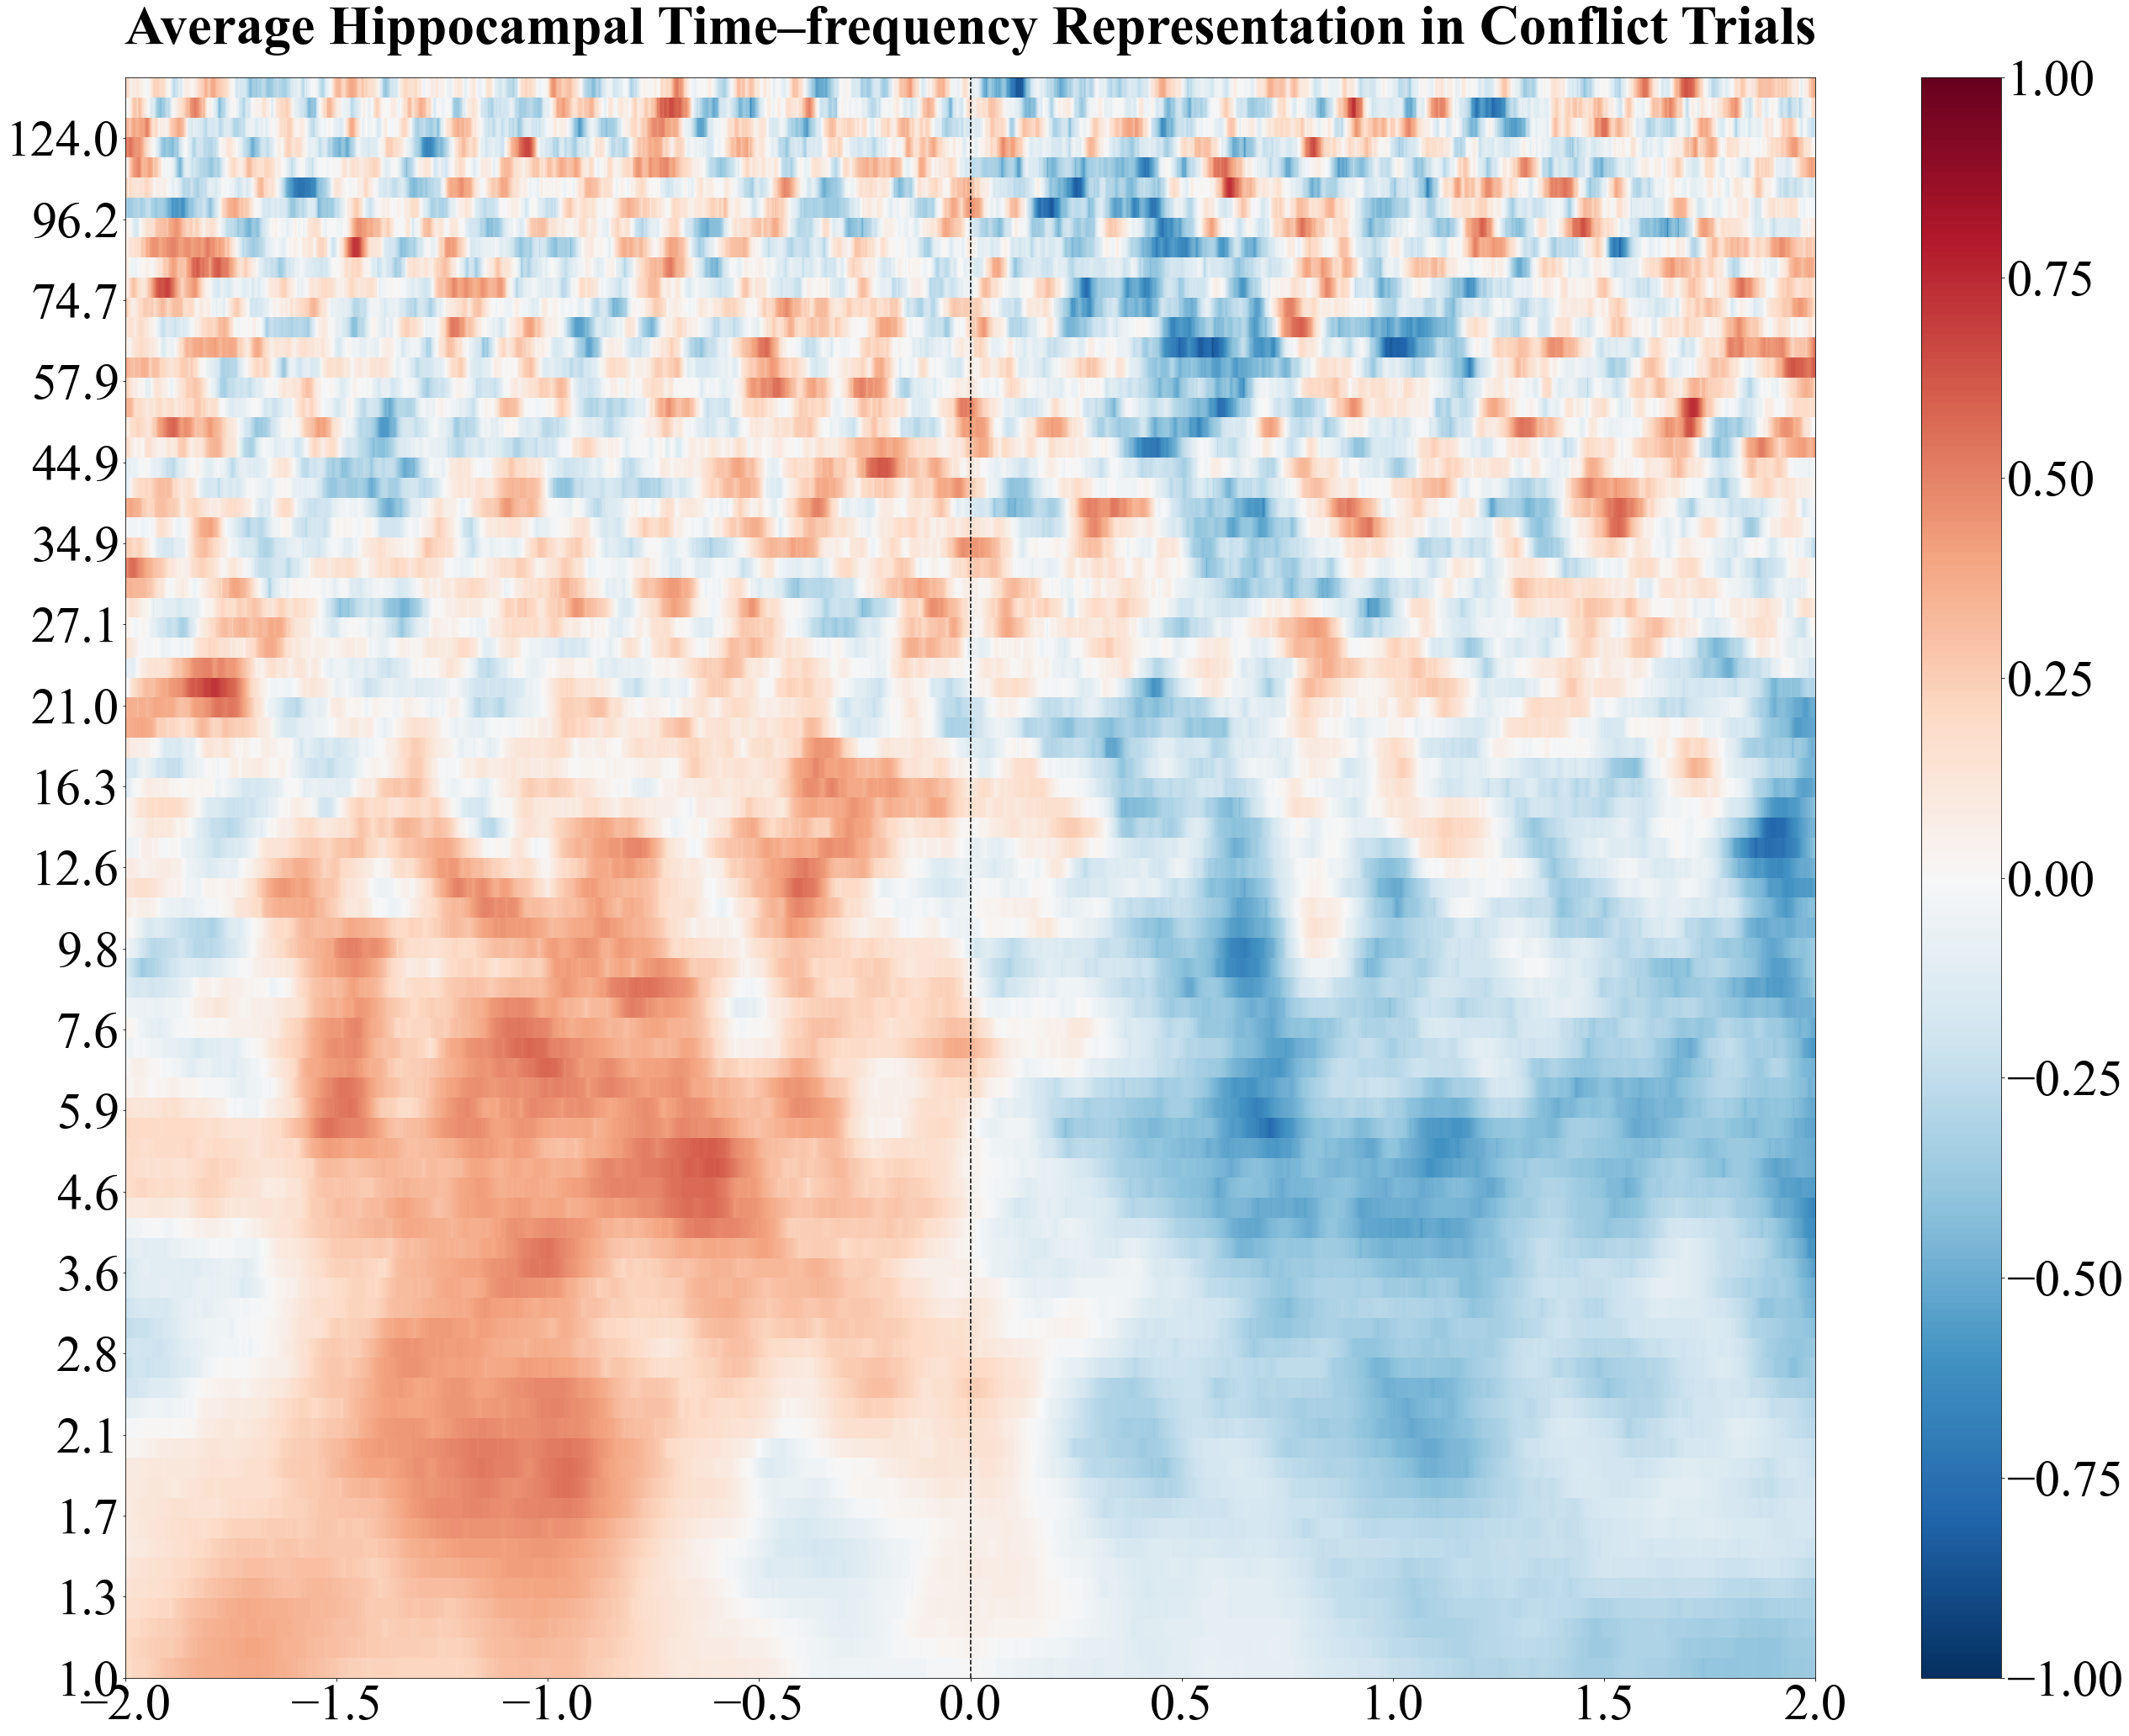

In [12]:
plot_allsub_averages(all_subs_ghost_average_hc, "Average Hippocampal Time–frequency Representation in Conflict Trials", 'average_hc_conflict_all_subs.png')

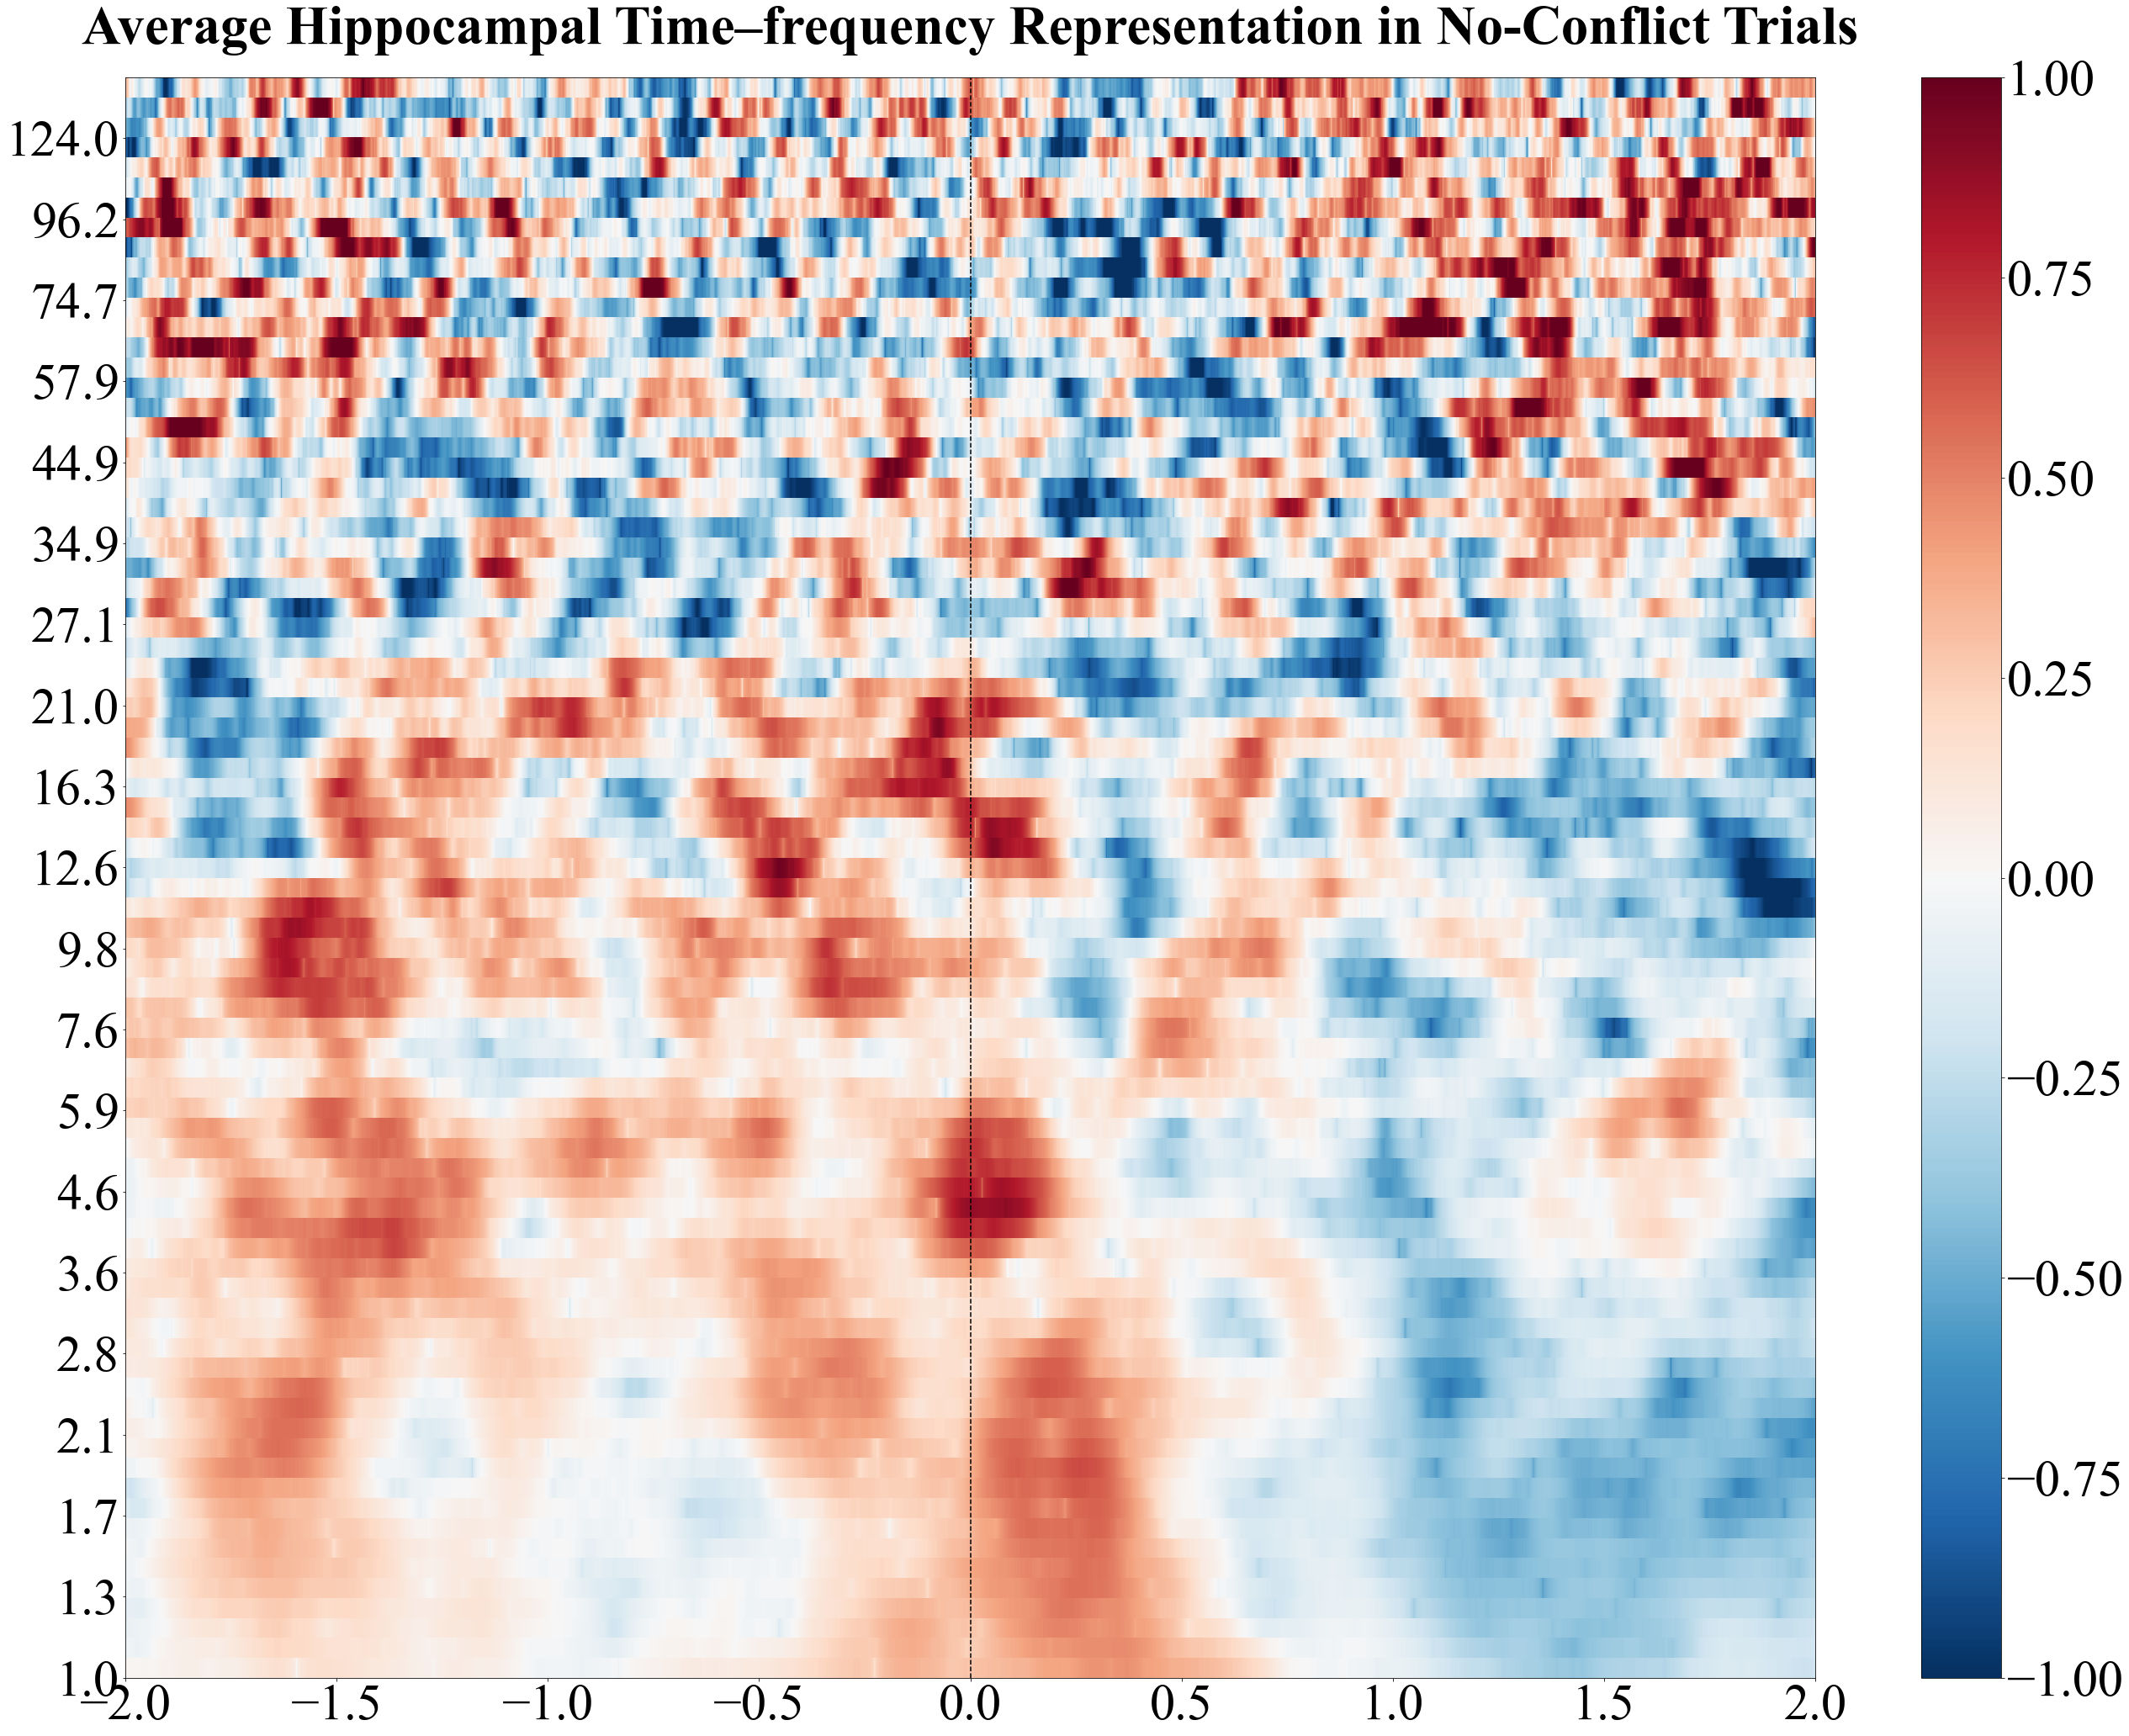

In [13]:
plot_allsub_averages(all_subs_noghost_average_hc, "Average Hippocampal Time–frequency Representation in No-Conflict Trials", 'average_hc_noconflict_all_subs.png')

## OFC

In [14]:
sub_list = ['SLCH002', 'BJH016', 'BJH021', 'BJH025', 'LL10', 'LL12', 'LL13']

all_subs_ghost_average_ofc, all_subs_noghost_average_ofc = calculate_last_away_average(sub_list, 'ofc')
    
np.save('../ieeg/all_subs_ghost_average_ofc.npy', all_subs_ghost_average_ofc)
np.save('../ieeg/all_subs_noghost_average_ofc.npy', all_subs_noghost_average_ofc)    

Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/SLCH002/ieeg/last_away/ofc_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/SLCH002/ieeg/last_away/ofc_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/last_away/ofc_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/last_away/ofc_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH021/ieeg/last_away/ofc_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH021/ieeg/last_away/ofc_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH025/ieeg/last_away/ofc_ghost-tfr.h5 ...
Adding m

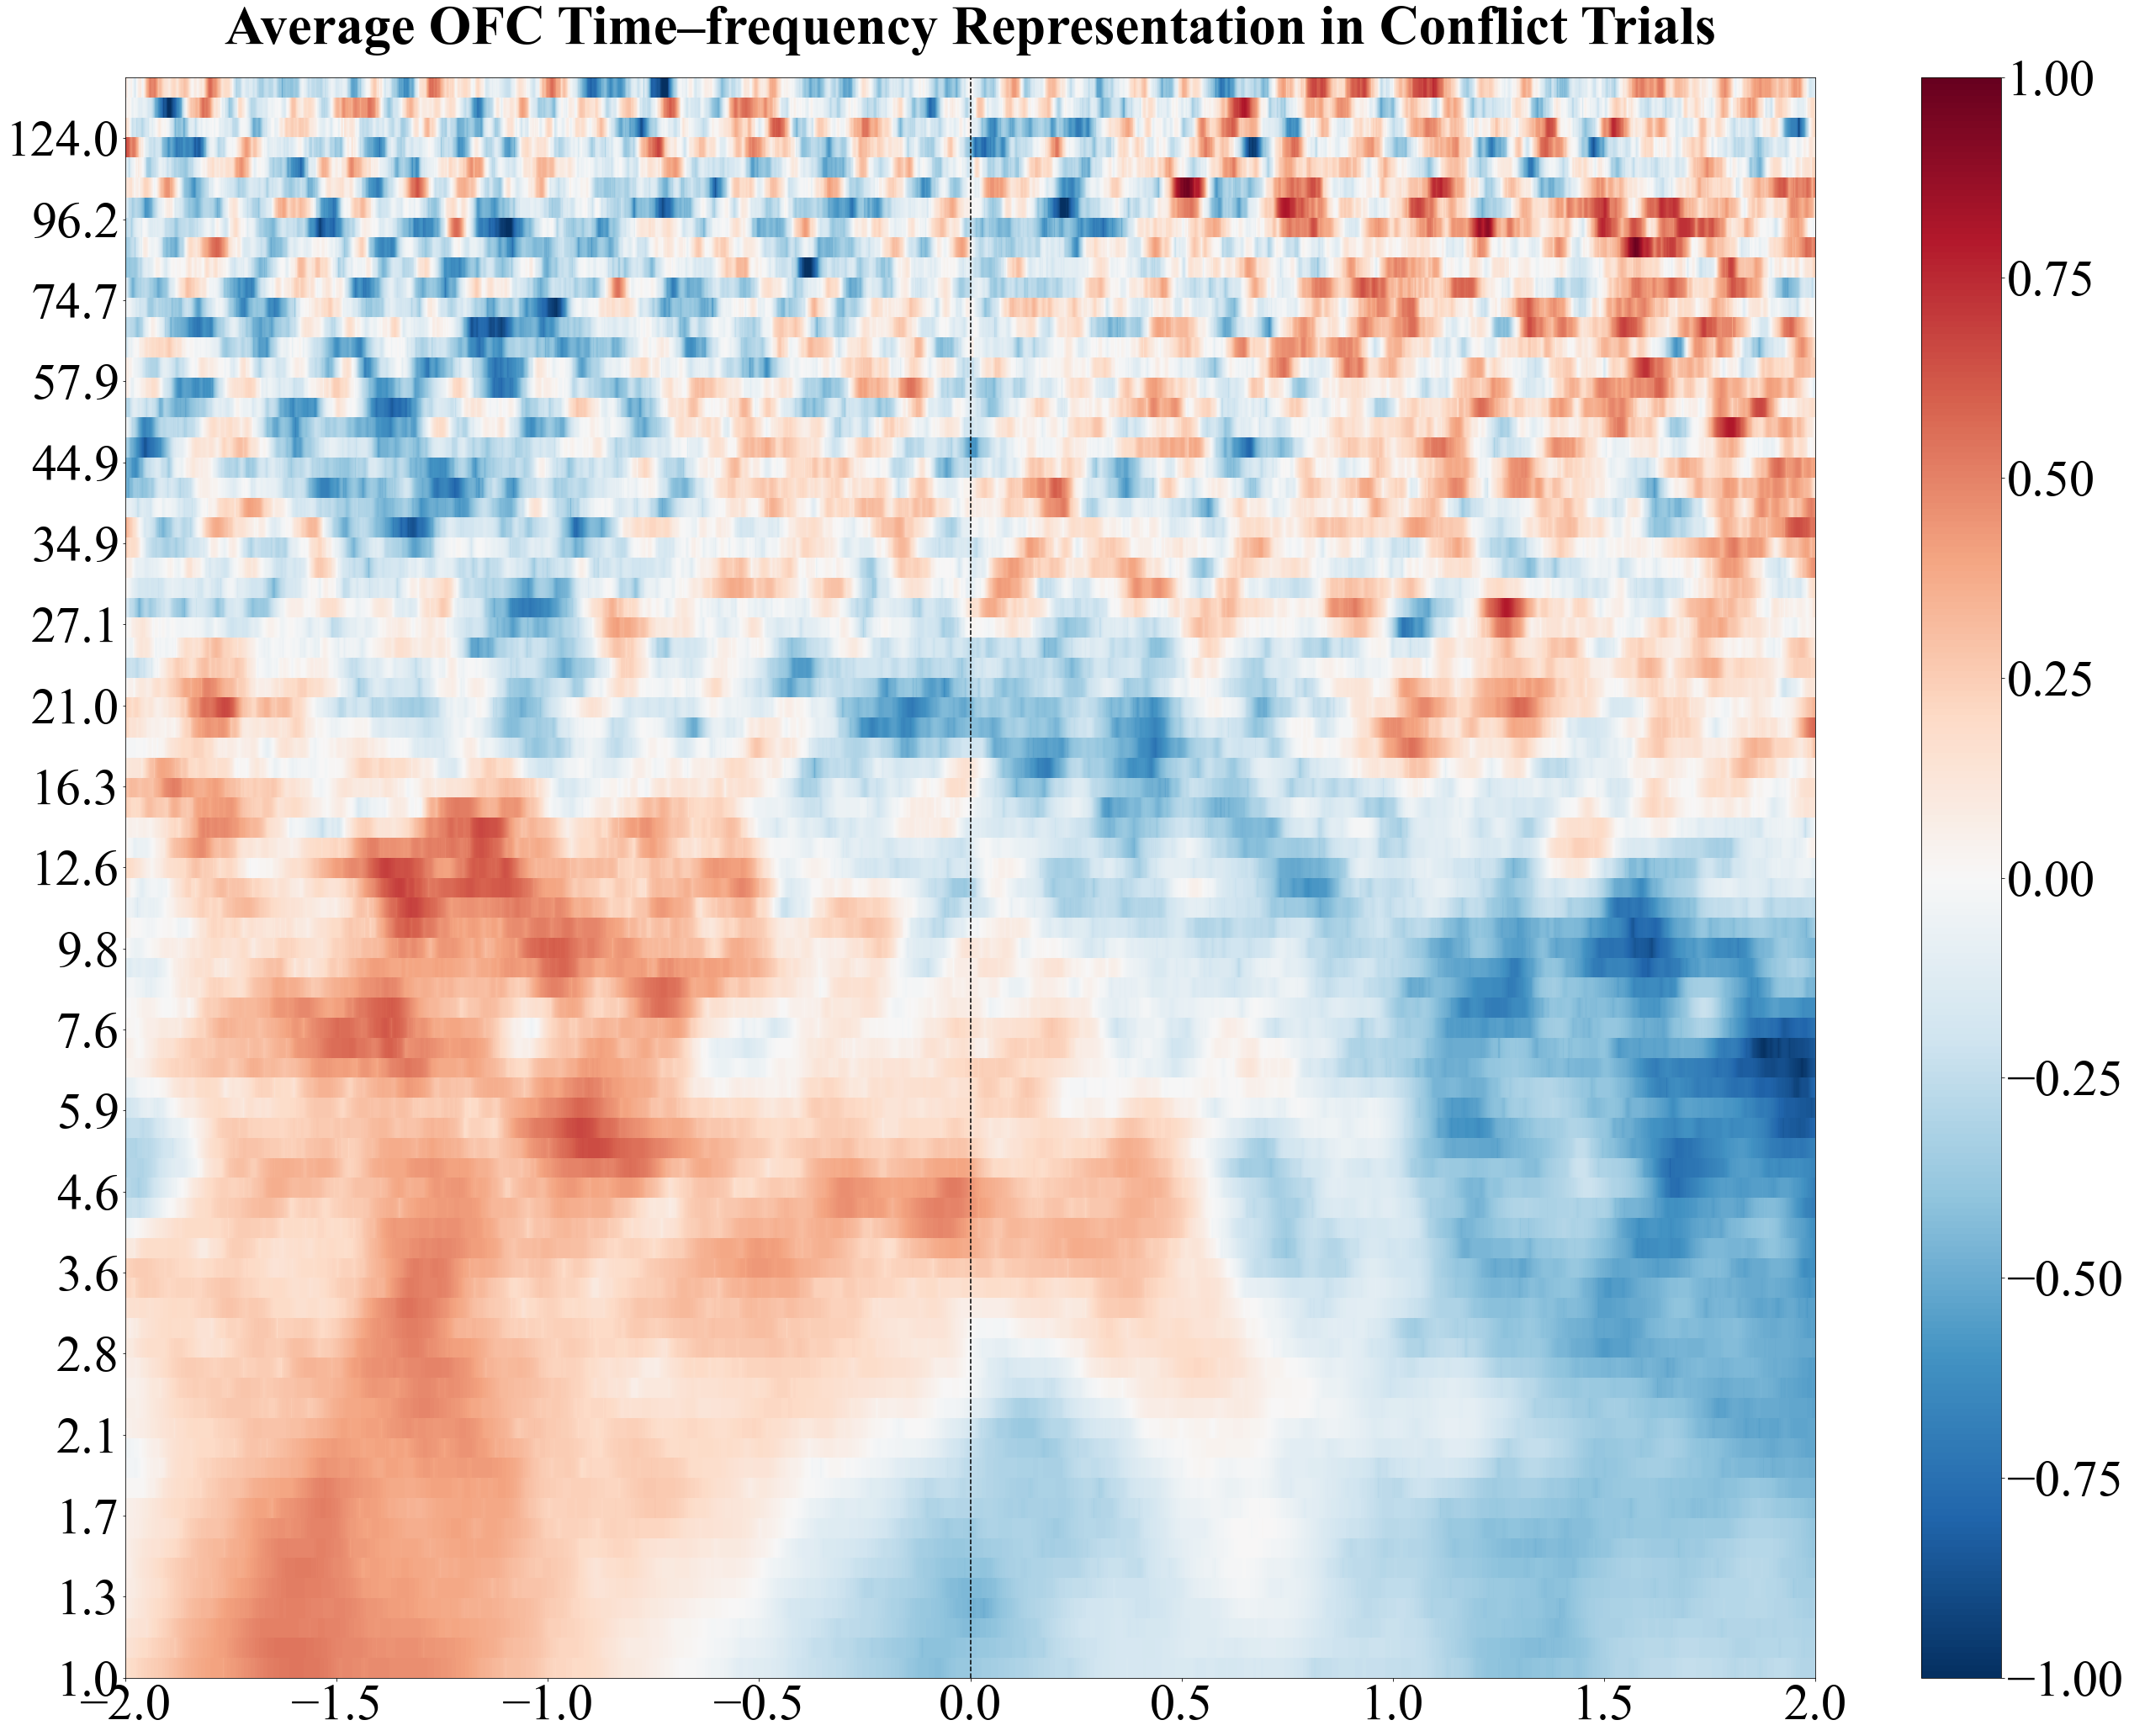

In [15]:
plot_allsub_averages(all_subs_ghost_average_ofc, "Average OFC Time–frequency Representation in Conflict Trials", 'average_ofc_conflict_all_subs.png')

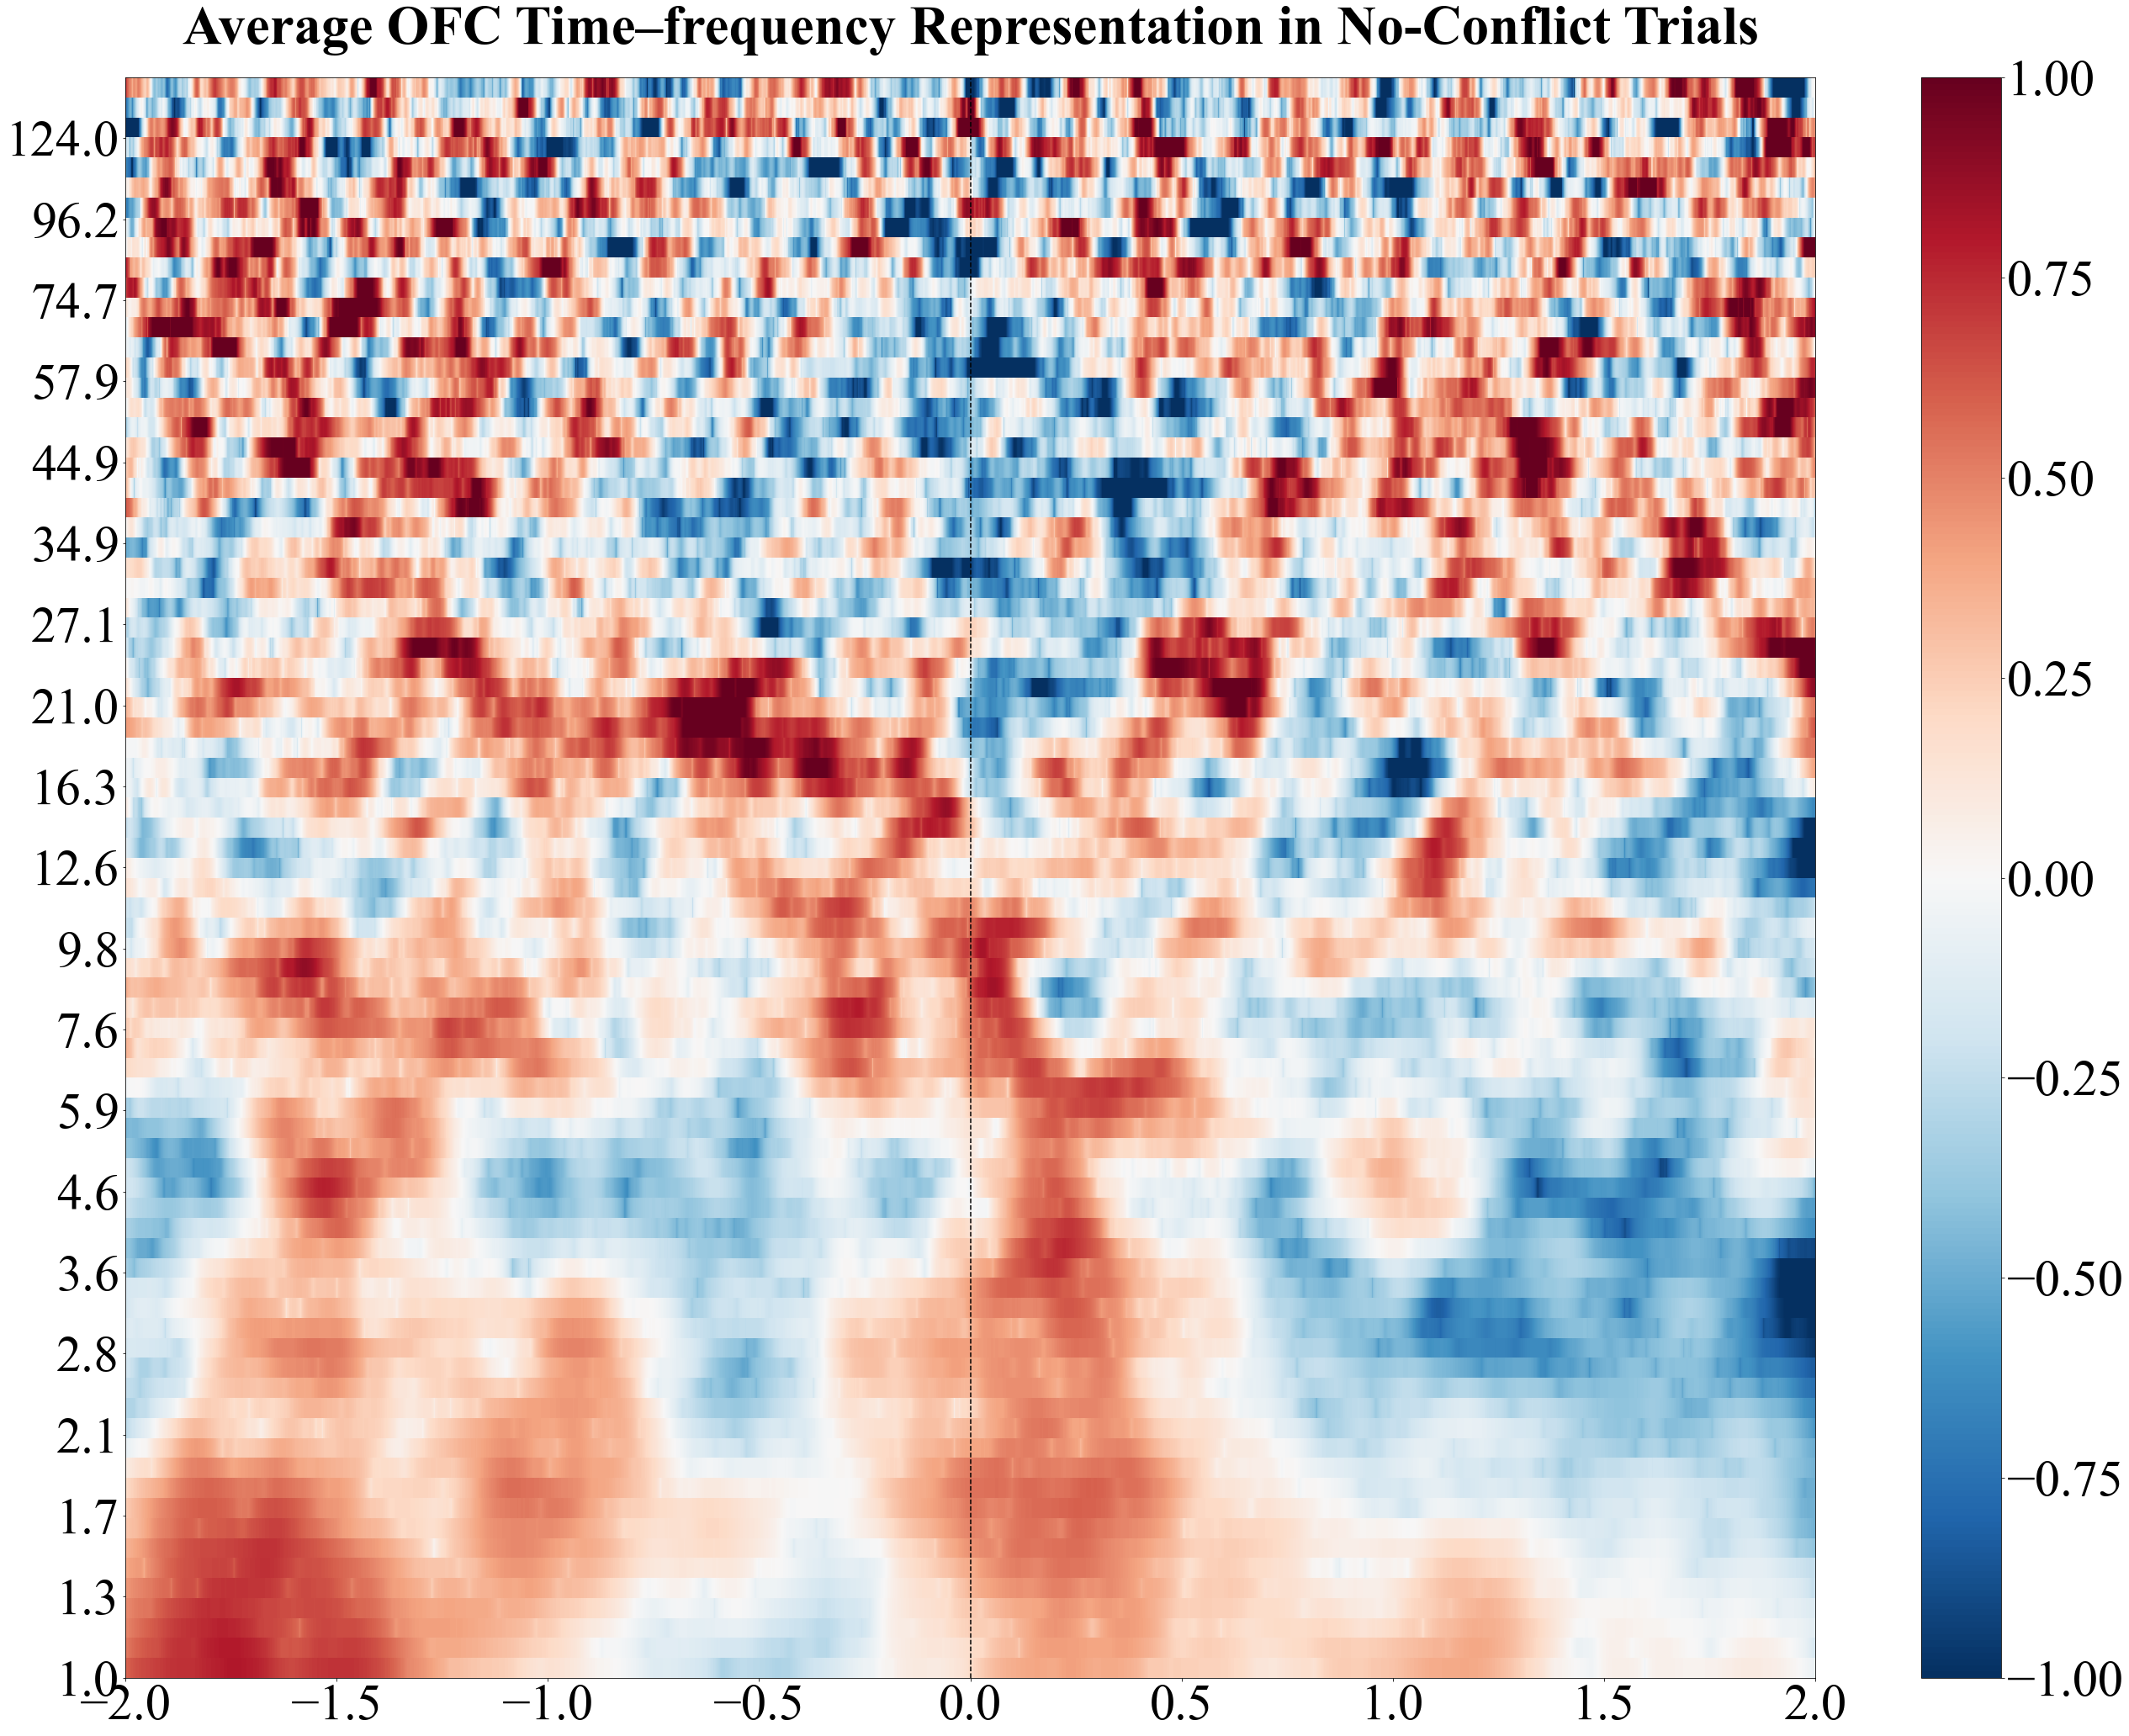

In [16]:
plot_allsub_averages(all_subs_noghost_average_ofc, "Average OFC Time–frequency Representation in No-Conflict Trials", 'average_ofc_noconflict_all_subs.png')

## Anterior Cingulate

In [18]:
sub_list = ['SLCH002', 'BJH016', 'BJH021', 'BJH025', 'LL10', 'LL12', 'LL13']

all_subs_ghost_average_cing, all_subs_noghost_average_cing = calculate_last_away_average(sub_list, 'cing')

np.save('../ieeg/all_subs_ghost_average_cing.npy', all_subs_ghost_average_cing)
np.save('../ieeg/all_subs_noghost_average_cing.npy', all_subs_noghost_average_cing)

Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/SLCH002/ieeg/last_away/cing_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/SLCH002/ieeg/last_away/cing_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/last_away/cing_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/last_away/cing_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH021/ieeg/last_away/cing_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH021/ieeg/last_away/cing_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH025/ieeg/last_away/cing_ghost-tfr.h5 ...
A

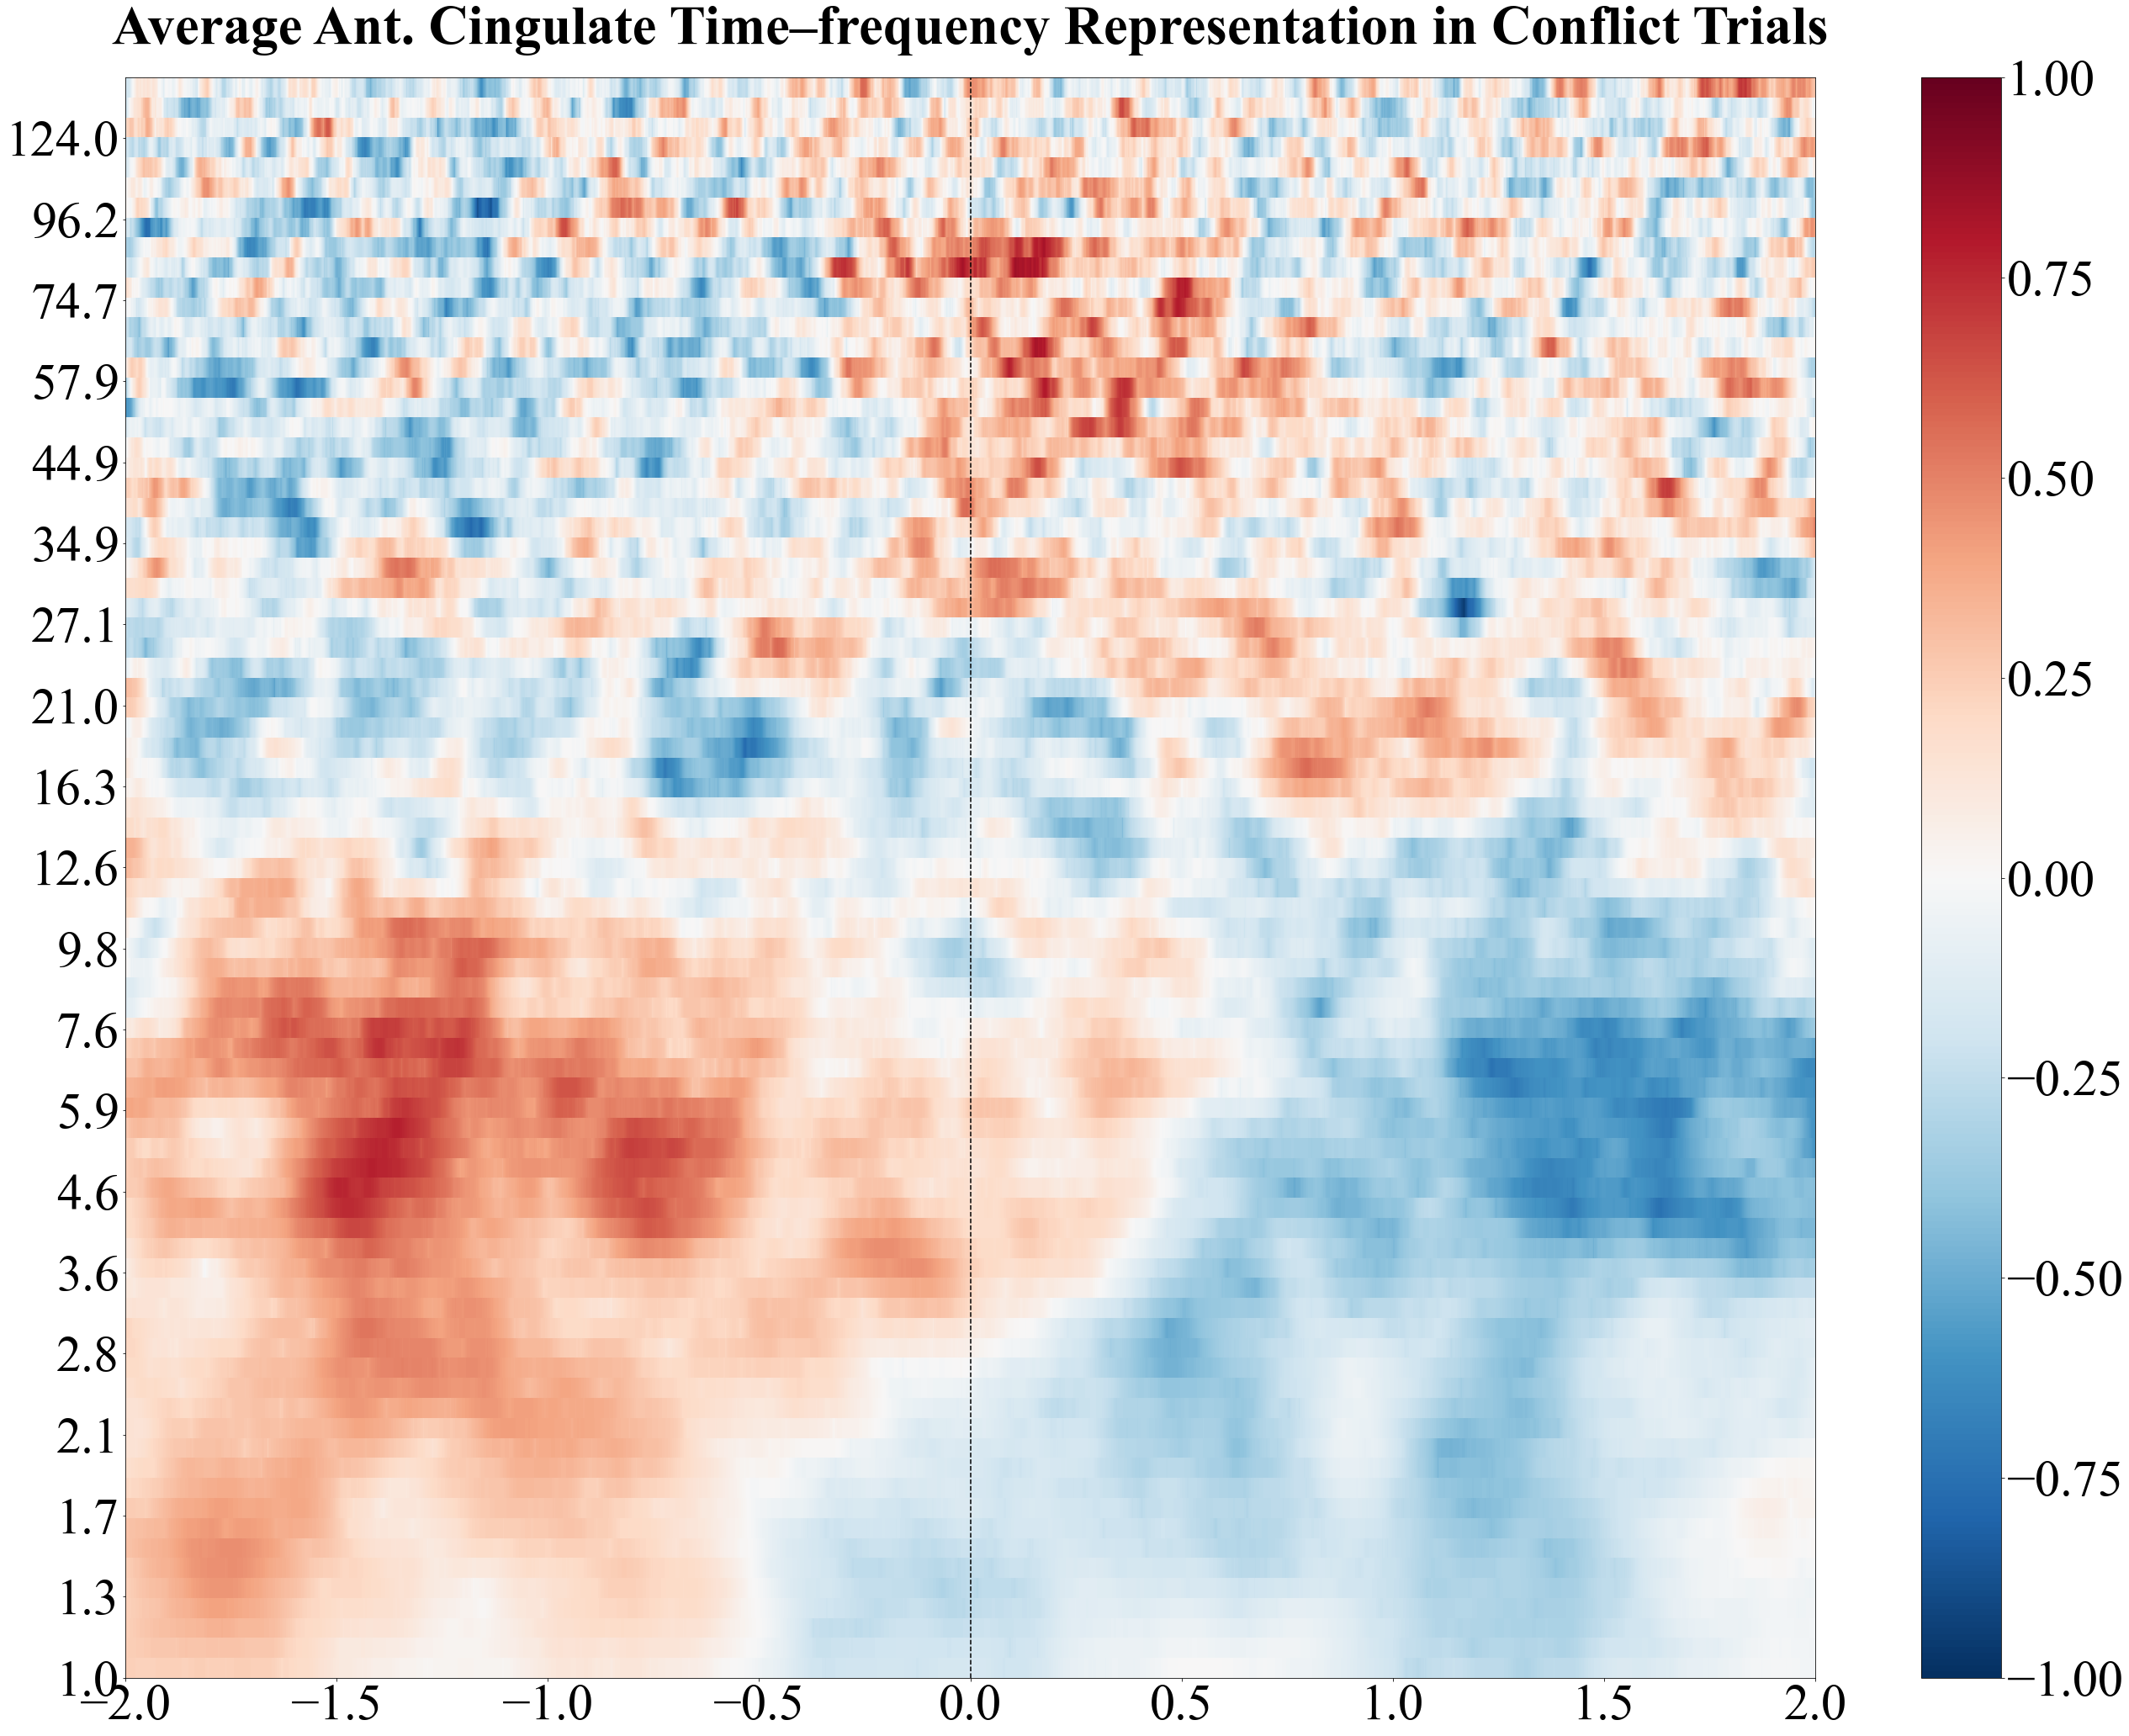

In [19]:
plot_allsub_averages(all_subs_ghost_average_cing, "Average Ant. Cingulate Time–frequency Representation in Conflict Trials", 'average_cing_conflict_all_subs.png')

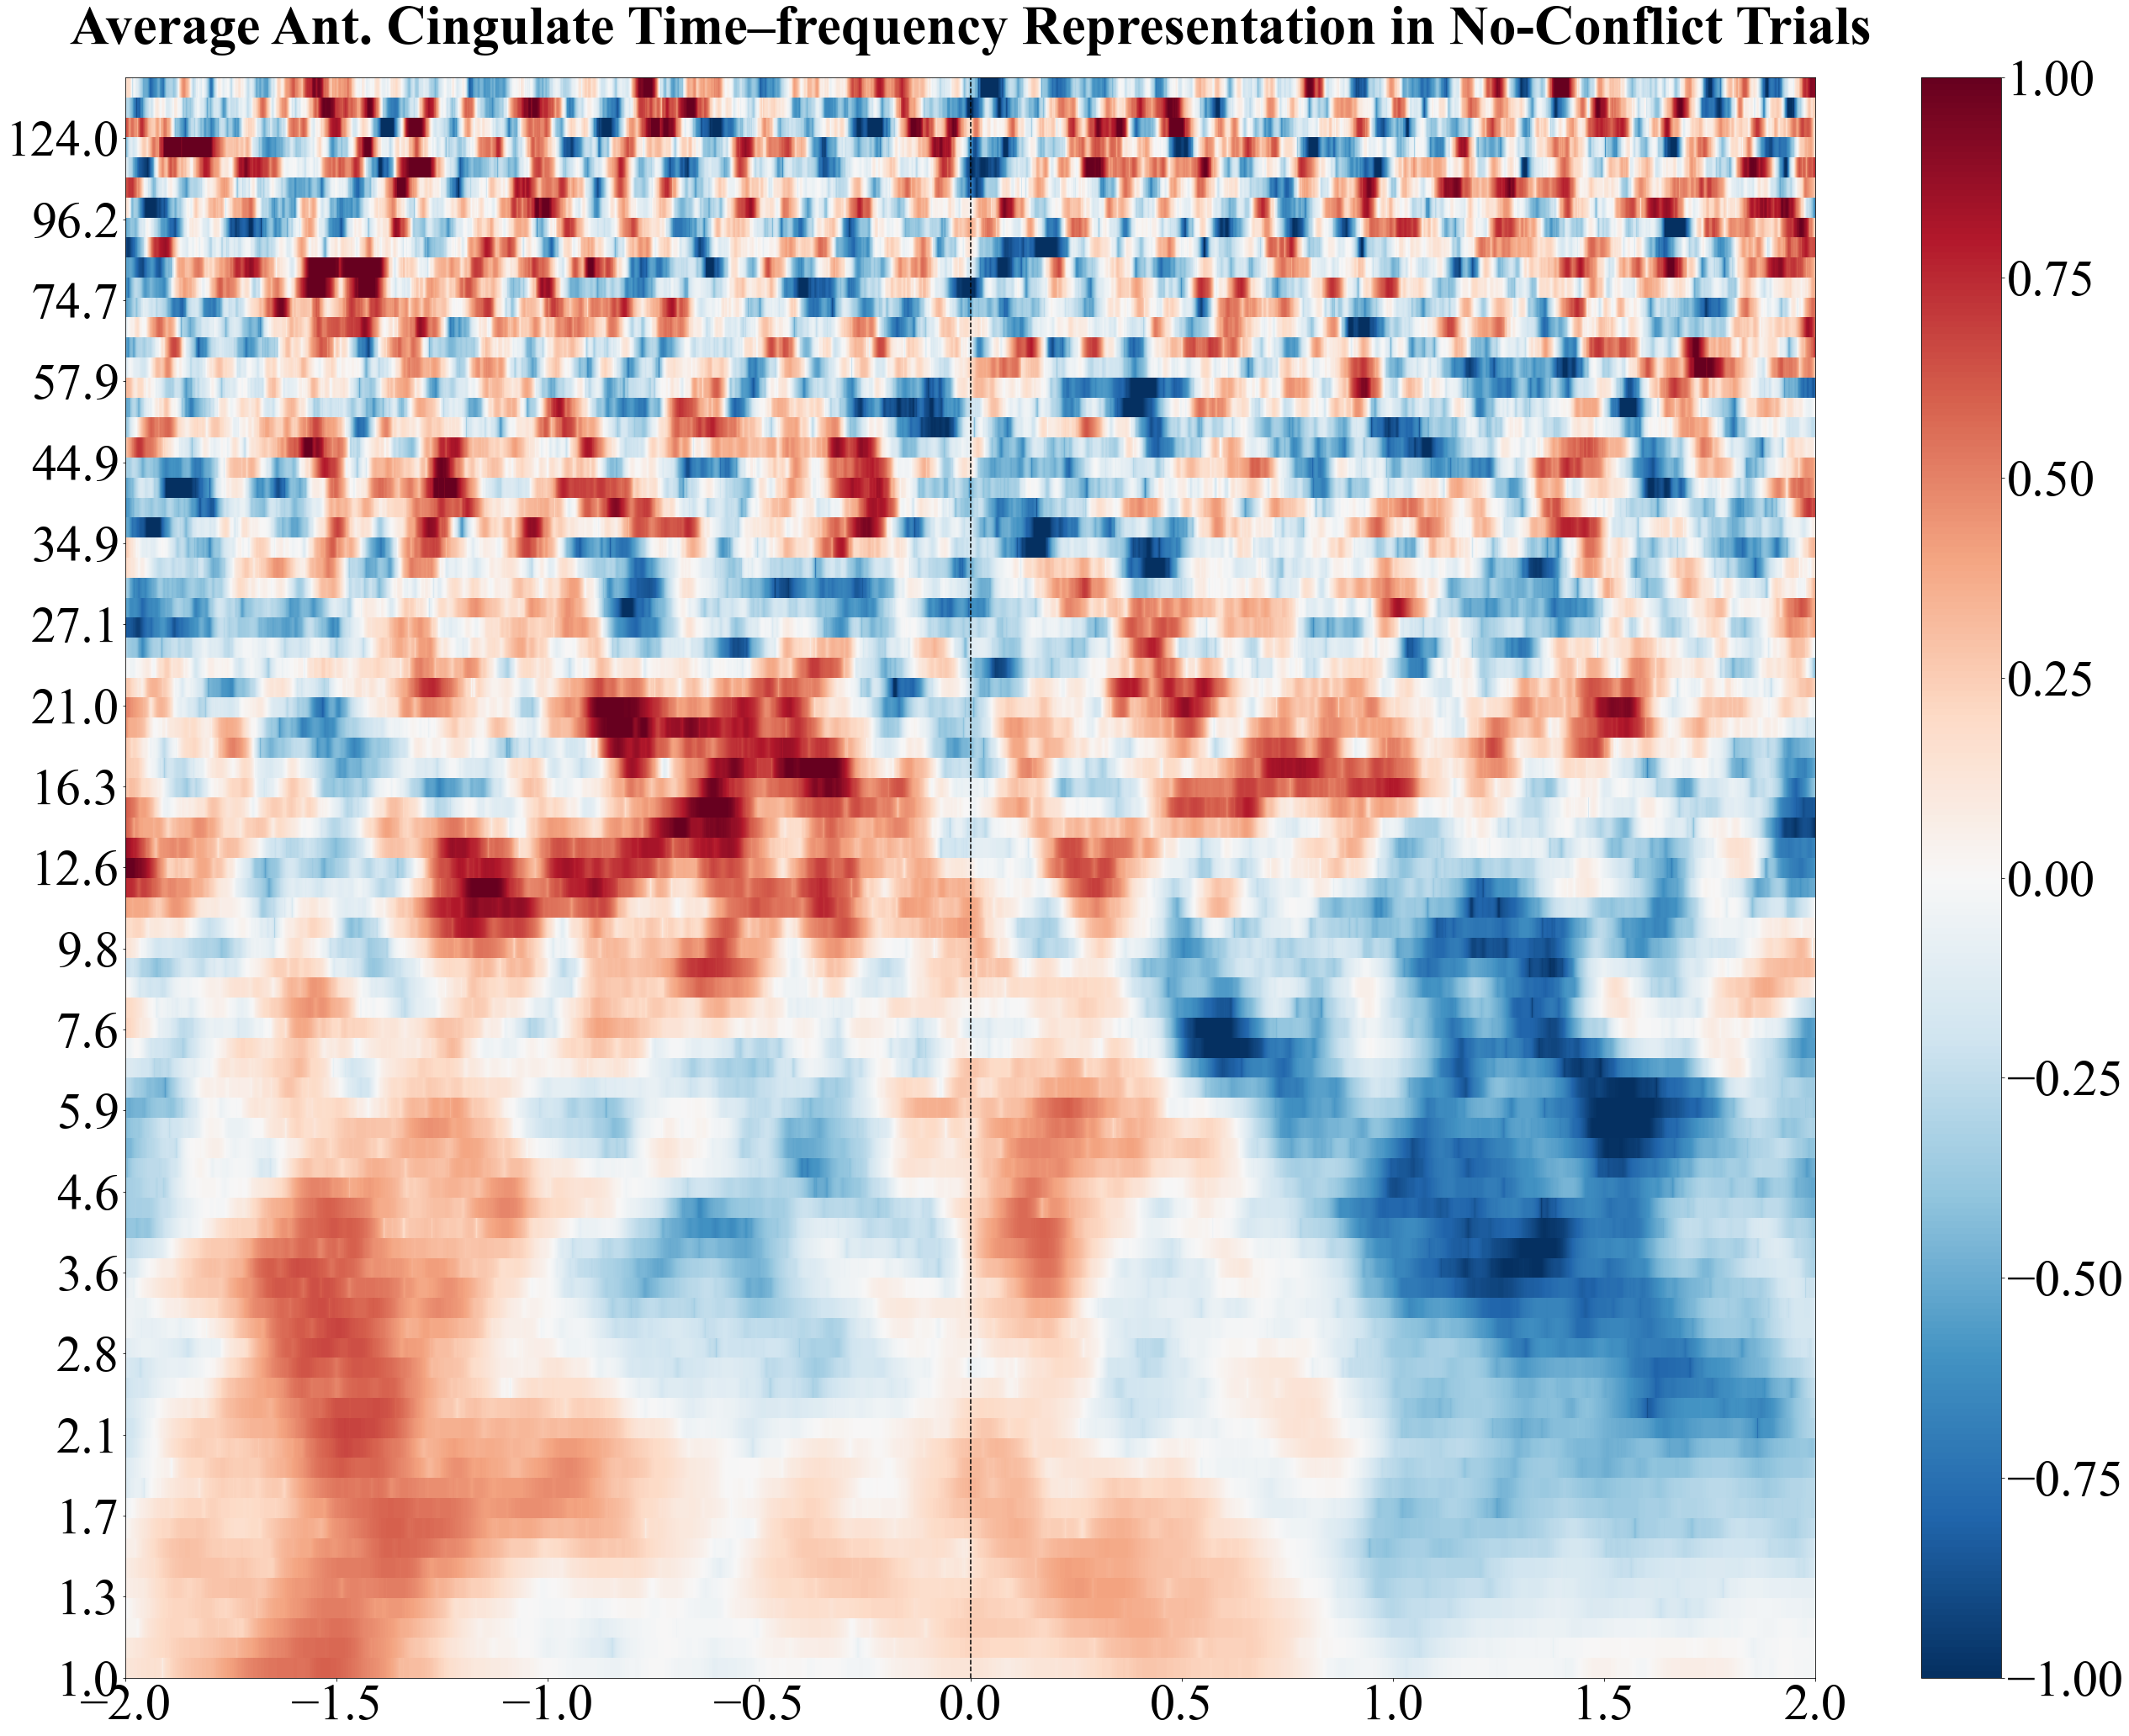

In [20]:
plot_allsub_averages(all_subs_noghost_average_cing, "Average Ant. Cingulate Time–frequency Representation in No-Conflict Trials", 'average_cing_noconflict_all_subs.png')

## Amygdala

In [21]:
sub_list = ['SLCH002', 'BJH016', 'BJH021', 'BJH025', 'LL10', 'LL12', 'LL13']

all_subs_ghost_average_amyg, all_subs_noghost_average_amyg = calculate_last_away_average(sub_list, 'amyg')
    
np.save('../ieeg/all_subs_ghost_average_amyg.npy', all_subs_ghost_average_amyg)
np.save('../ieeg/all_subs_noghost_average_amyg.npy', all_subs_noghost_average_amyg)    

Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/SLCH002/ieeg/last_away/amyg_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/SLCH002/ieeg/last_away/amyg_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/last_away/amyg_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/last_away/amyg_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH021/ieeg/last_away/amyg_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH021/ieeg/last_away/amyg_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH025/ieeg/last_away/amyg_ghost-tfr.h5 ...
A

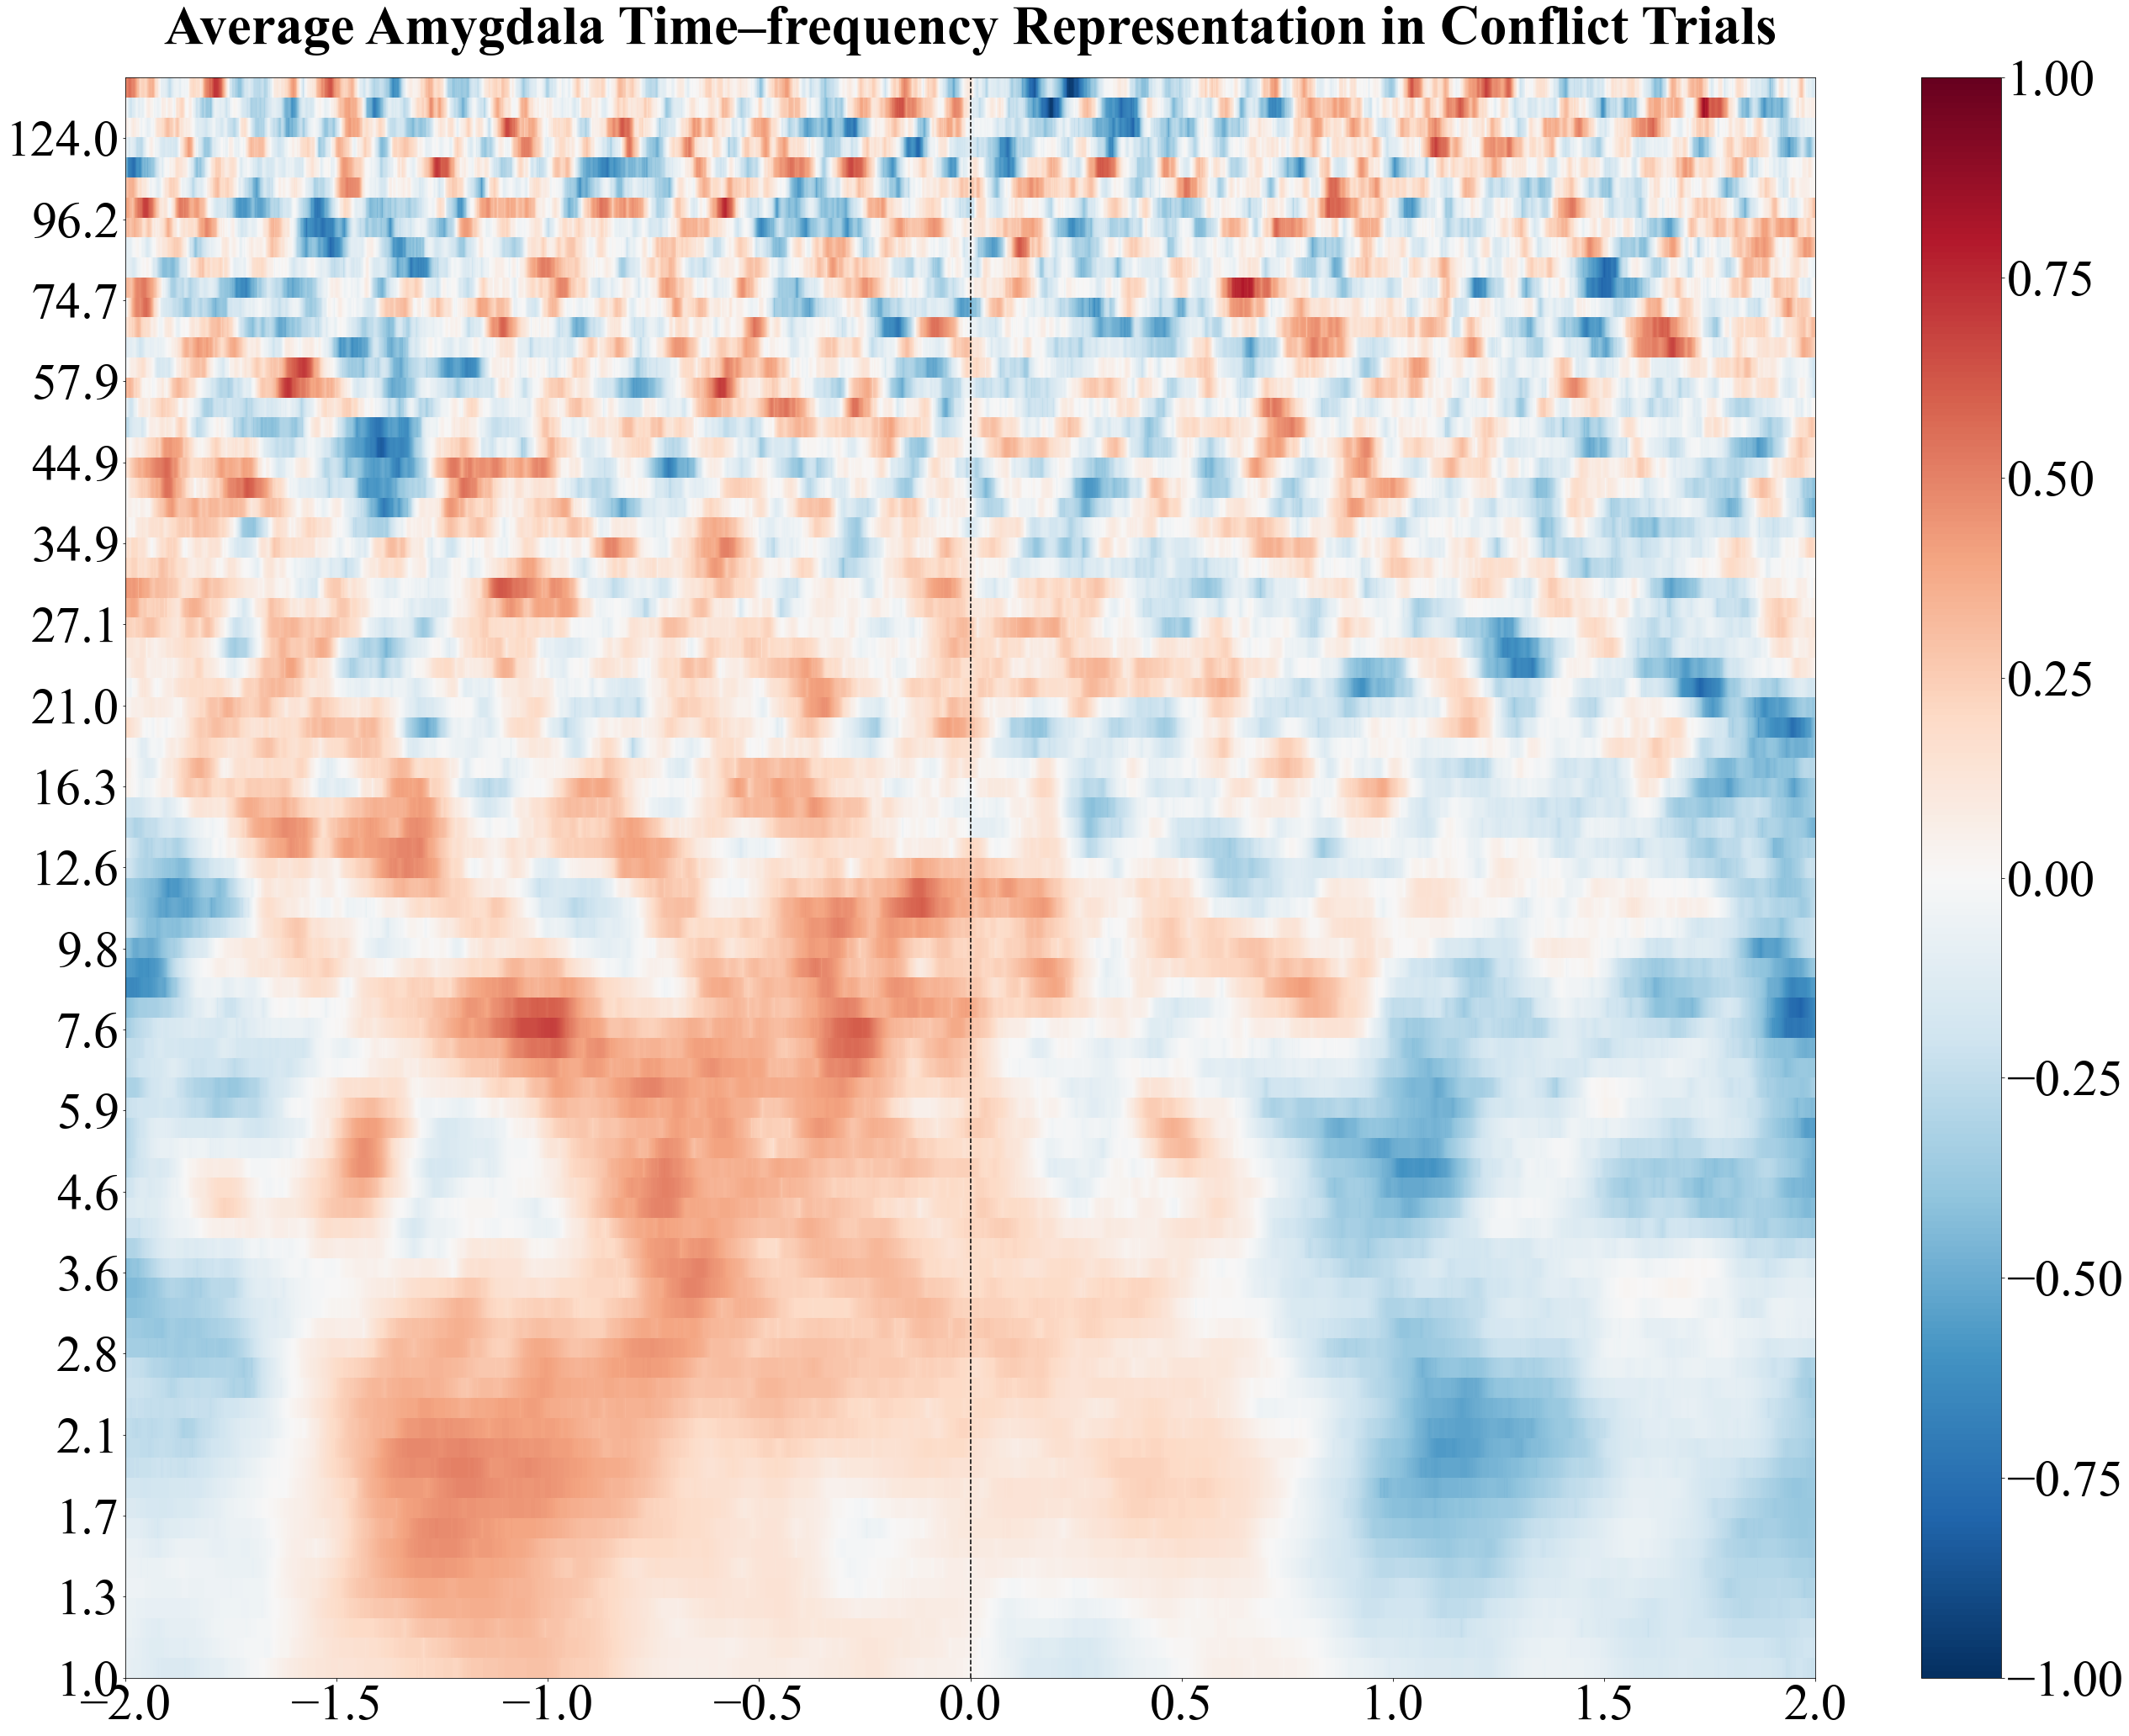

In [22]:
plot_allsub_averages(all_subs_ghost_average_amyg, "Average Amygdala Time–frequency Representation in Conflict Trials", 'average_amyg_conflict_all_subs.png')

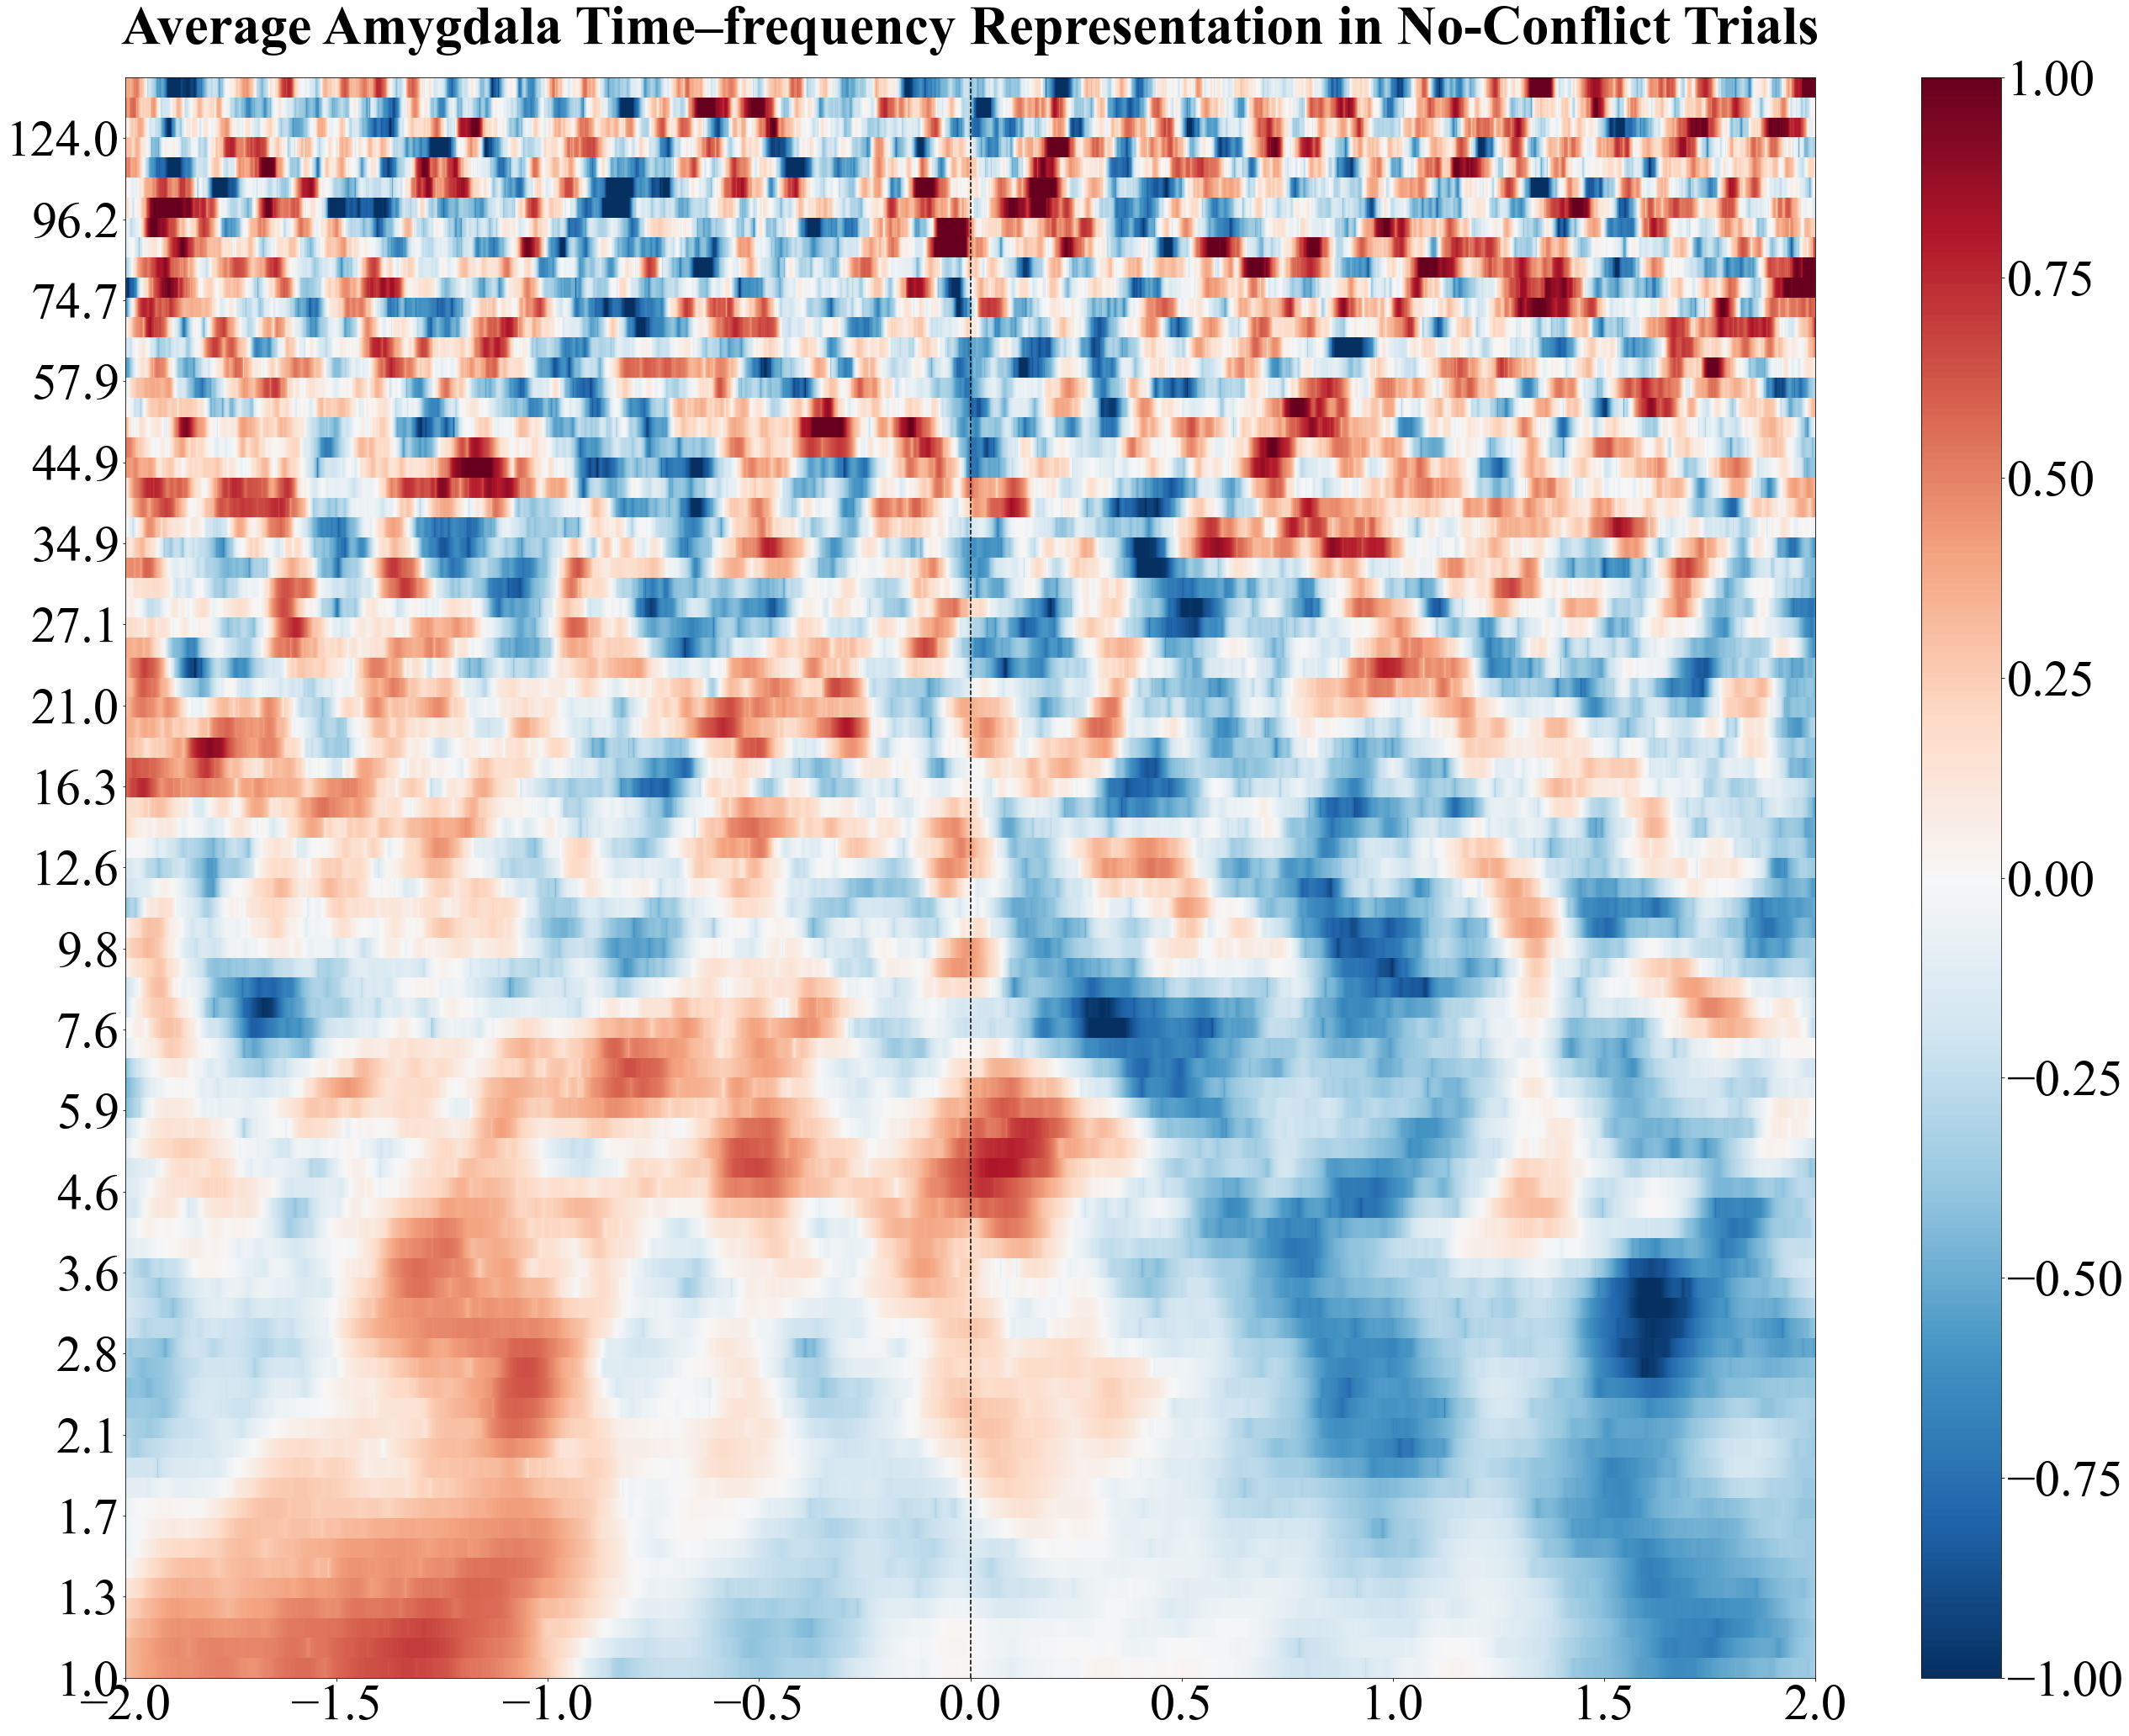

In [23]:
plot_allsub_averages(all_subs_noghost_average_amyg, "Average Amygdala Time–frequency Representation in No-Conflict Trials", 'average_amyg_noconflict_all_subs.png')

# Other Regions

## dlPFC

In [24]:
sub_list = ['SLCH002', 'BJH016', 'BJH021', 'BJH025', 'LL10', 'LL12', 'LL13']

all_subs_ghost_average_dlpfc, all_subs_noghost_average_dlpfc = calculate_last_away_average(sub_list, 'dlpfc')
    
np.save('../ieeg/all_subs_ghost_average_dlpfc.npy', all_subs_ghost_average_dlpfc)
np.save('../ieeg/all_subs_noghost_average_dlpfc.npy', all_subs_noghost_average_dlpfc)    

Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/SLCH002/ieeg/last_away/dlpfc_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/SLCH002/ieeg/last_away/dlpfc_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/last_away/dlpfc_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/last_away/dlpfc_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH021/ieeg/last_away/dlpfc_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH021/ieeg/last_away/dlpfc_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH025/ieeg/last_away/dlpfc_ghost-tfr.h

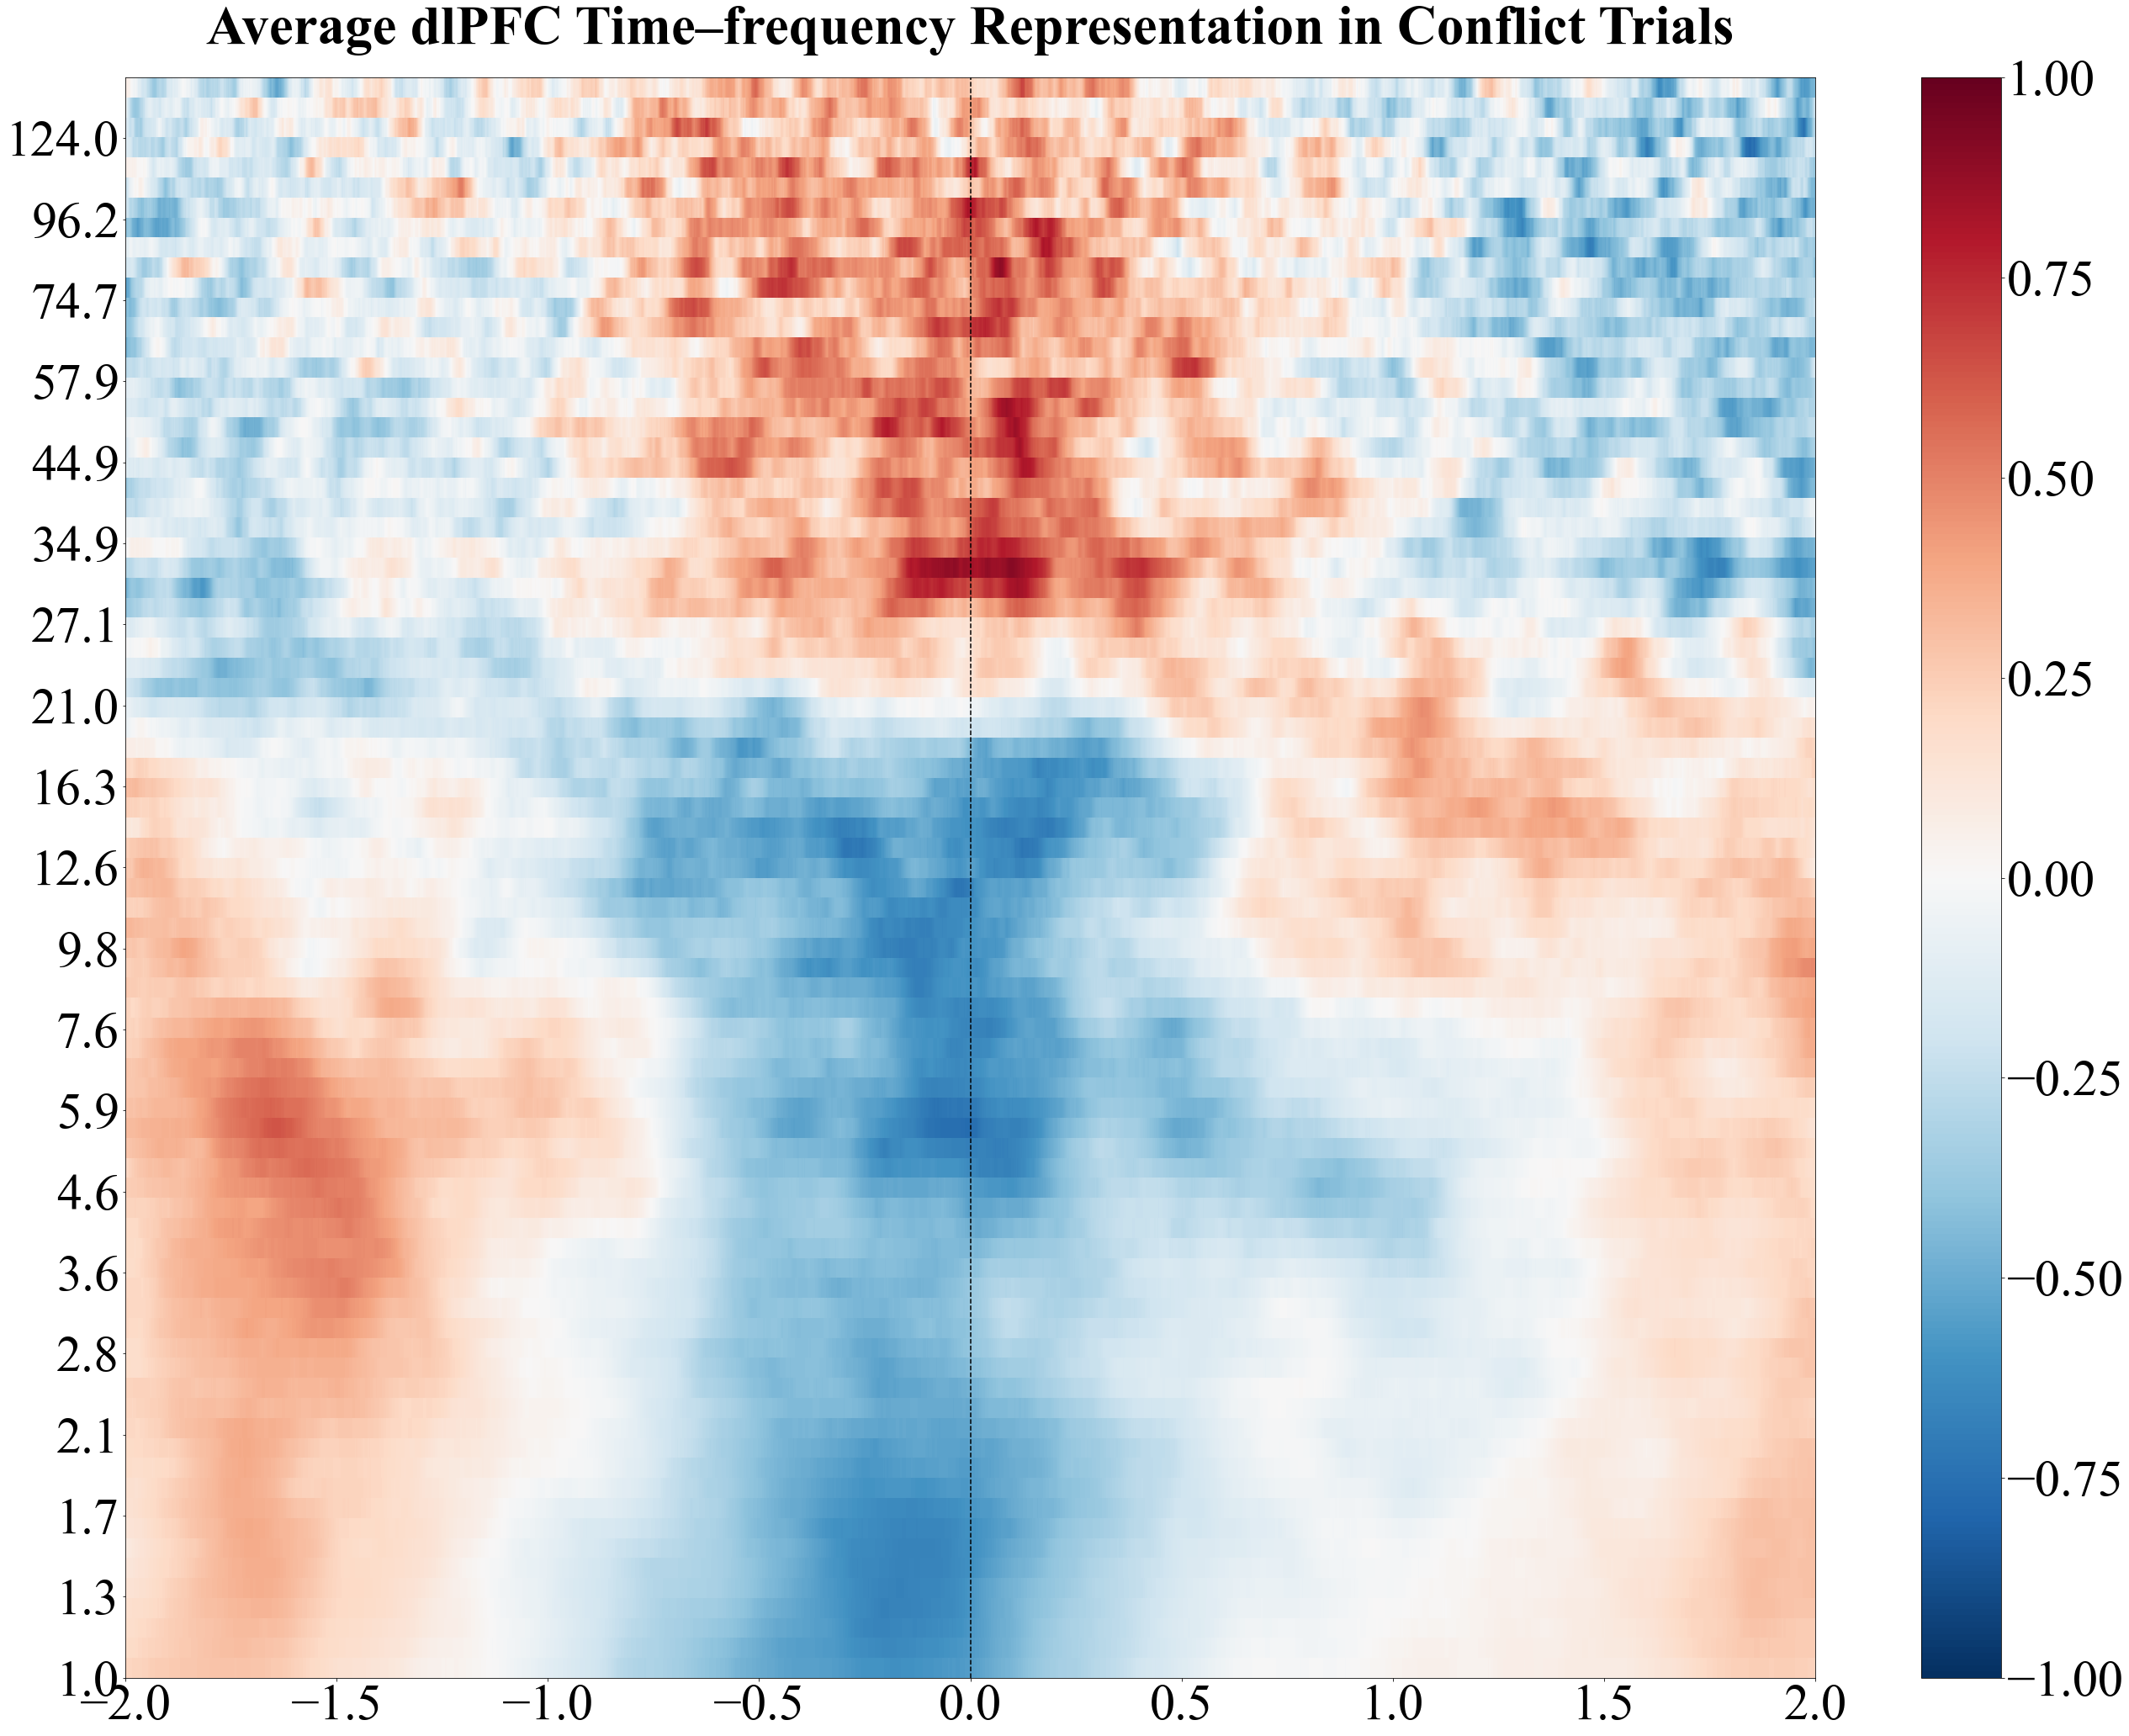

In [25]:
plot_allsub_averages(all_subs_ghost_average_dlpfc, "Average dlPFC Time–frequency Representation in Conflict Trials", 'average_dlpfc_conflict_all_subs.png')

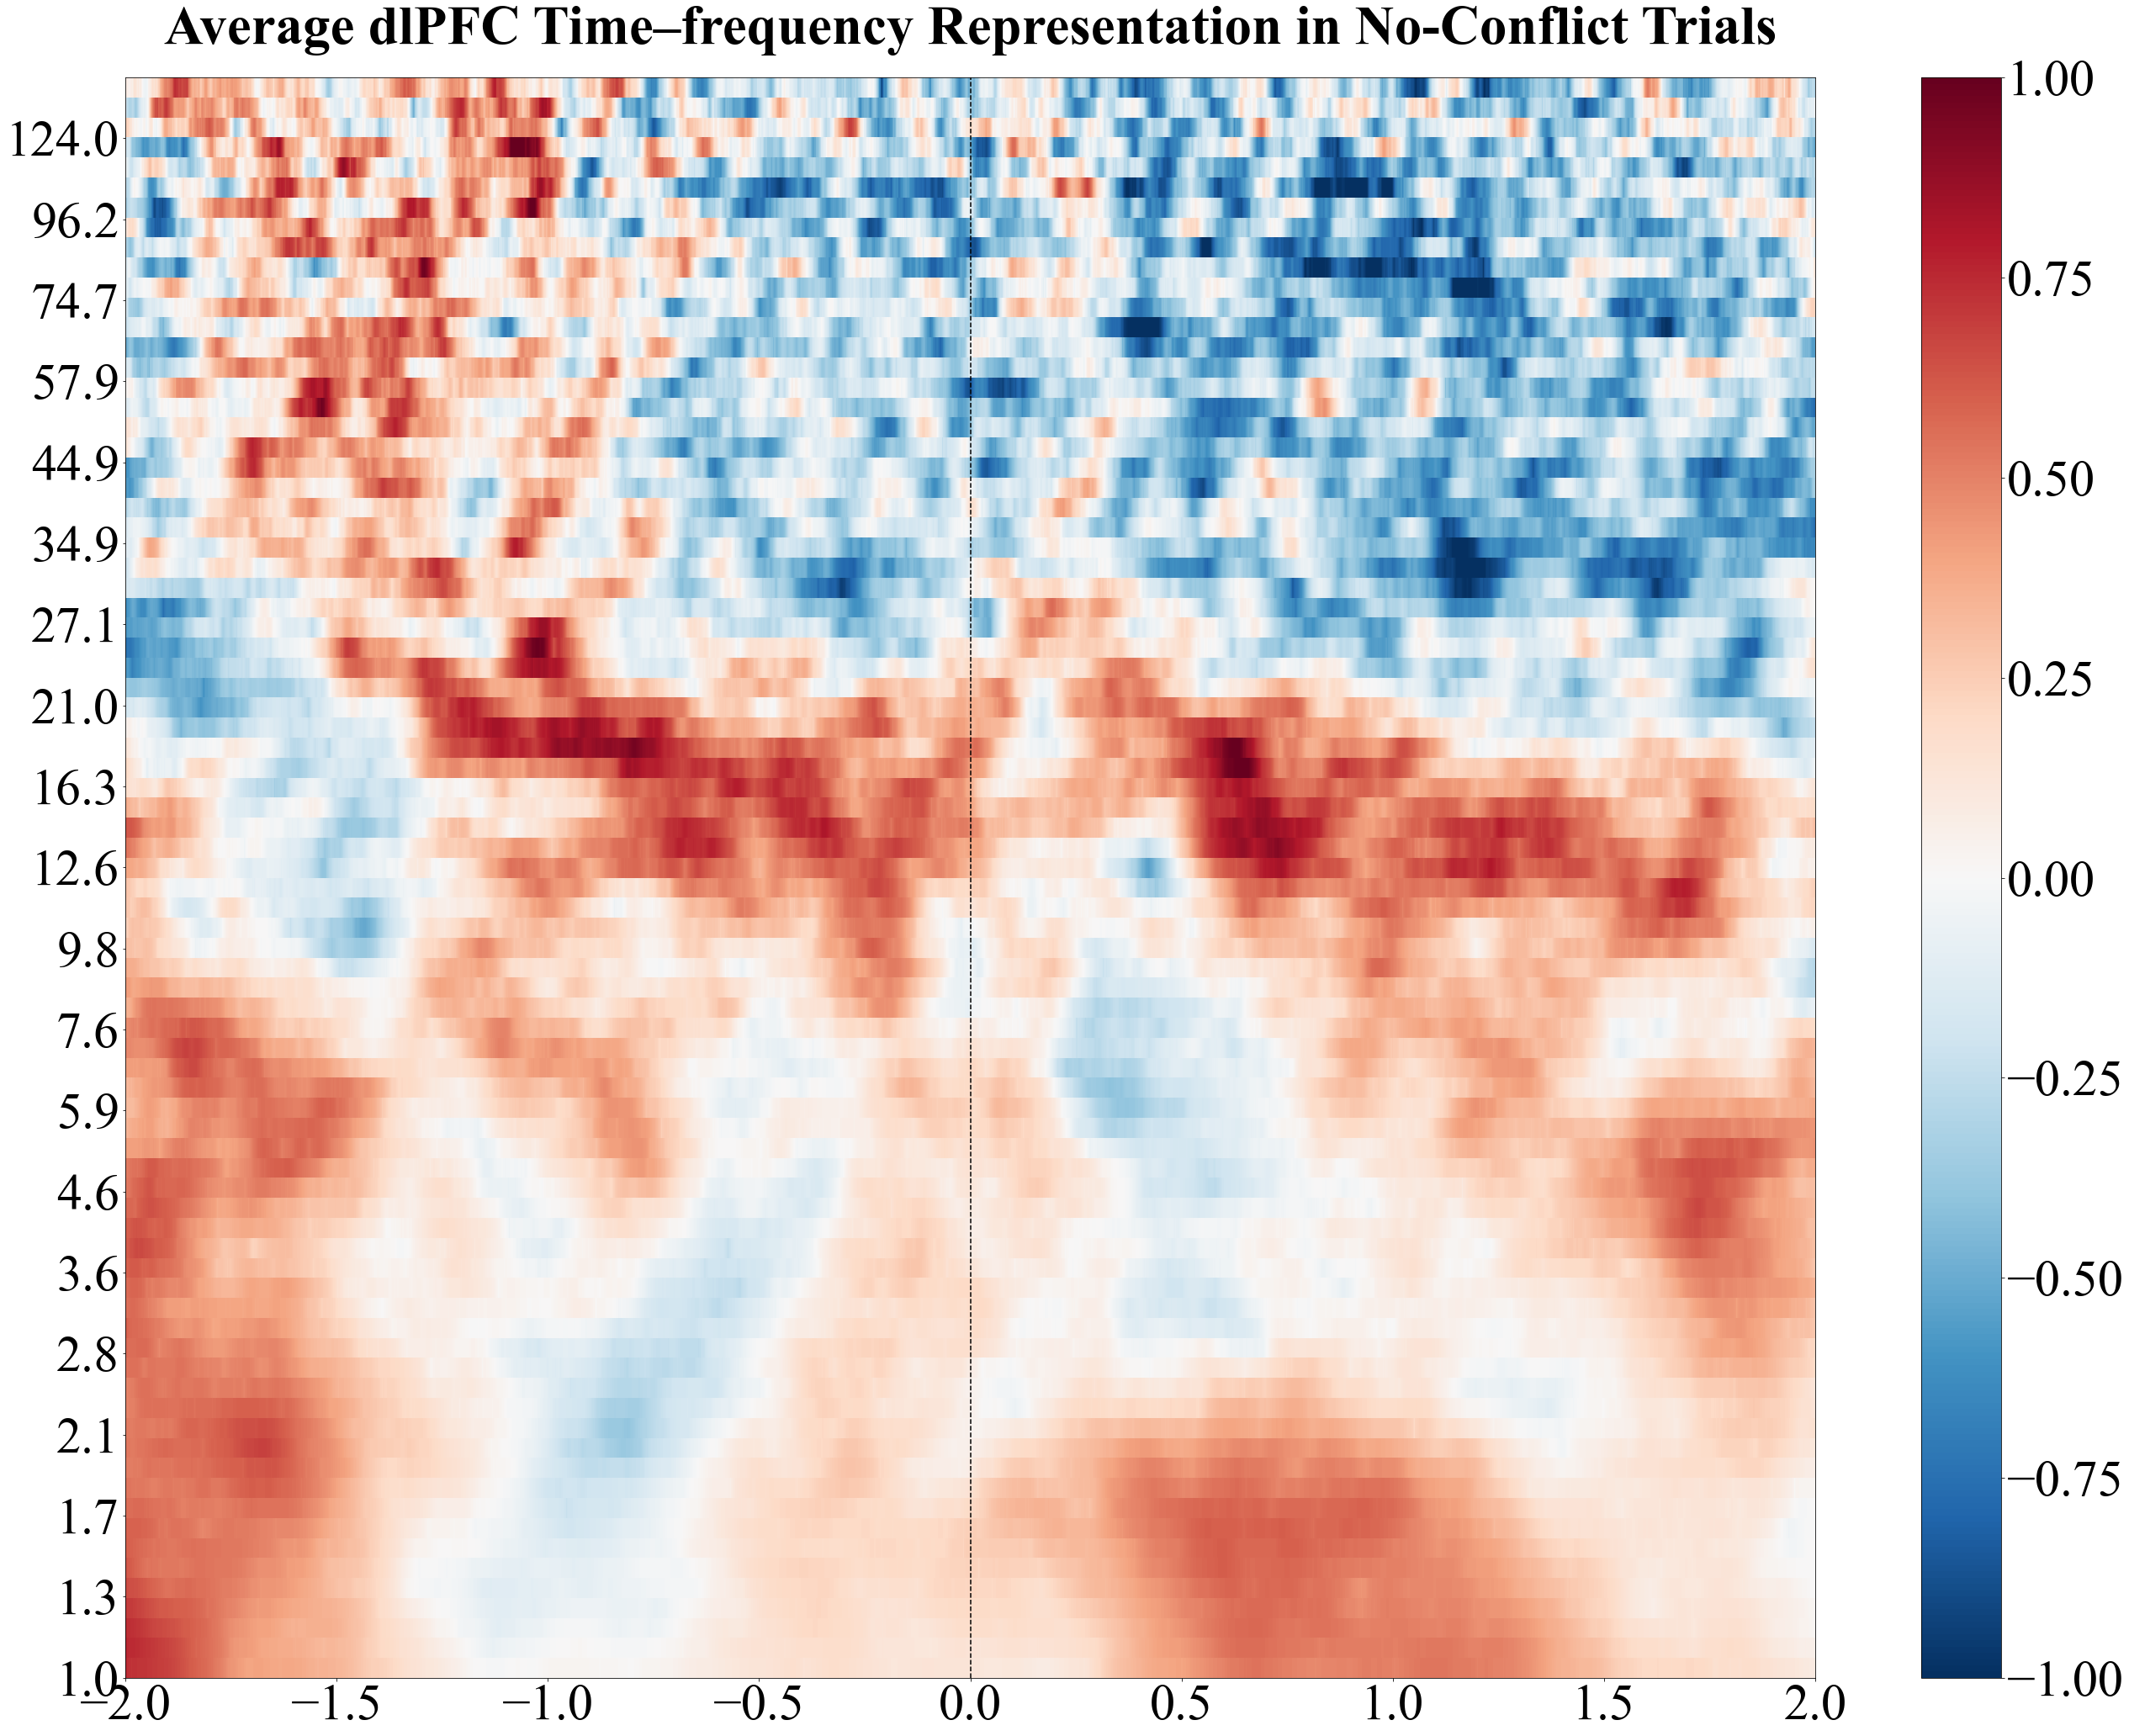

In [26]:
plot_allsub_averages(all_subs_noghost_average_dlpfc, "Average dlPFC Time–frequency Representation in No-Conflict Trials", 'average_dlpfc_noconflict_all_subs.png')

## Insula

In [ ]:
sub_list = ['SLCH002', 'BJH016', 'BJH021', 'BJH025', 'LL12']

all_subs_ghost_average_insula, all_subs_noghost_average_insula = calculate_last_away_average(sub_list, 'insula')
    
np.save('../ieeg/all_subs_ghost_average_insula.npy', all_subs_ghost_average_insula)
np.save('../ieeg/all_subs_noghost_average_insula.npy', all_subs_noghost_average_insula)    

Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/SLCH002/ieeg/last_away/insula_ghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/SLCH002/ieeg/last_away/insula_noghost-tfr.h5 ...
Adding metadata with 5 columns
Reading /home/brooke/knight_server/remote/bstavel/pacman/preprocessing/BJH016/ieeg/last_away/insula_ghost-tfr.h5 ...


In [ ]:
plot_allsub_averages(all_subs_ghost_average_insula, "Average Insula Time–frequency Representation in Conflict Trials", 'average_insula_conflict_all_subs.png')

In [ ]:
plot_allsub_averages(all_subs_noghost_average_insula, "Average Insula Time–frequency Representation in No-Conflict Trials", 'average_insula_noconflict_all_subs.png')

## EC

In [ ]:
sub_list = ['SLCH002', 'BJH016', 'BJH025']

all_subs_ghost_average_ec, all_subs_noghost_average_ec = calculate_last_away_average(sub_list, 'ec')
    
np.save('../ieeg/all_subs_ghost_average_ec.npy', all_subs_ghost_average_ec)
np.save('../ieeg/all_subs_noghost_average_ec.npy', all_subs_noghost_average_ec)

In [ ]:
plot_allsub_averages(all_subs_ghost_average_ec, "Average Entorhinal Cortex Time–frequency Representation in Conflict Trials", 'average_ec_conflict_all_subs.png')

In [ ]:
plot_allsub_averages(all_subs_noghost_average_ec, "Average Entorhinal Cortex Time–frequency Representation in No-Conflict Trials", 'average_ec_noconflict_all_subs.png')